In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F

import os
import glob
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa # librosa: Audio handling package
import random
import copy
import re
import jamotools

from tqdm import tqdm_notebook as tqdm # tqdm: Pakage for progress bar visualization
from datetime import datetime

import threading
import queue

import Levenshtein as Lev

In [2]:
n_mels = 80
fs = 16000
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

# meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
# data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'

# meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
# data_folder = "D:/korean-single-speaker-speech-dataset/kss"

data_folder = "D:/nsml-dataset/train_data/"
label_path = "D:/nsml-dataset/hackathon.labels"

data_list = glob.glob(data_folder + '*.csv')[0]

wav_paths = list()
script_paths = list()
korean_script_paths = list()

with open(data_list, 'r') as f:
    for line in f:
        # line: "aaa.wav,aaa.label"
        wav_path, script_path = line.strip().split(',')
        korean_script_path = script_path.replace('.label', '.script')
        
        wav_paths.append(os.path.join(data_folder, wav_path))
        script_paths.append(os.path.join(data_folder, script_path))
        korean_script_paths.append(os.path.join(data_folder, korean_script_path))

dataset_size = len(wav_paths)

In [3]:
def get_label(filepath, bos_id, eos_id):
    key = filepath.split('/')[-1].split('.')[0]
    script = target_dict[key]
    tokens = script.split(' ')
    result = list()
    result.append(bos_id)
    for i in range(len(tokens)):
        if len(tokens[i]) > 0:
            result.append(int(tokens[i]))
    result.append(eos_id)
    return result

In [4]:
print("wav_paths len: {}".format(len(wav_paths)))
print("script_paths len: {}".format(len(script_paths)))
print("korean_script_paths len: {}".format(len(korean_script_paths)))

print(wav_paths[0])
print(script_paths[0])
print(korean_script_paths[0])

wav_paths len: 29805
script_paths len: 29805
korean_script_paths len: 29805
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.wav
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.label
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.script


In [12]:

script_list = list()

for script_path in tqdm(script_paths):
    with open(script_path) as f:
        line = f.read()
        line = line.strip()
        result = [0] + list(map(int, line.split(' '))) + [-1]
        script_list.append(result)

In [13]:
script_list[10]

[0, 255, 676, 295, 179, 610, 662, 749, 62, 661, 123, 662, -1]

In [6]:
def load_label(label_path):
    char2index = dict() # [ch] = id
    index2char = dict() # [id] = ch
    with open(label_path, 'r', encoding='UTF-8') as f:
    # with open(label_path, 'r') as f:
        for no, line in enumerate(f):
            if line[0] == '#': 
                continue

            index, char, freq = line.strip().split('\t')
            char = char.strip()
            if len(char) == 0:
                char = ' '

            char2index[char] = int(index)
            index2char[int(index)] = char

    return char2index, index2char

In [7]:
char2index, index2char = load_label(label_path)
SOS_token = char2index['<s>']  # '<sos>' or '<s>'
EOS_token = char2index['</s>']  # '<eos>' or '</s>'
PAD_token = char2index['_']  # '-' or '_'

In [8]:
print('char2index len: {}'.format(len(char2index)))

print('index2char len: {}'.format(len(index2char)))

char2index len: 820
index2char len: 820


In [9]:
pure_jamo_list = list()

# 초성
for unicode in range(0x1100, 0x1113):
    pure_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# 중성
for unicode in range(0x1161, 0x1176):
    pure_jamo_list.append(chr(unicode))
# 종성
for unicode in range(0x11A8, 0x11C3):
    pure_jamo_list.append(chr(unicode))

pure_jamo_list += [' ', '!', ',', '.', '?']

print(pure_jamo_list)

['ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ', ' ', '!', ',', '.', '?']


In [10]:
korean_script_list = list()
jamo_script_list = list()

# true_jamo_regex_not  = re.compile(u'[^, .?!\u1100-\u115e\u1161-\u11A7\u11a8-\u11ff]+')

# valid_regex = re.compile(u'[,_ ^.?!？~<>:;/%()+A-Za-z0-9\u1100-\u115e\u1161-\u11A7\u11a8-\u11ff]+')

count = 0

for file in tqdm(korean_script_paths):
    with open(file, 'r', encoding='utf-8') as f:
        line = f.read()
        line = line.strip()
        korean_script_list.append(line)
        jamo = list(jamotools.split_syllables(line, 'JAMO'))
        
#         print(len(jamo))
        for i, c in enumerate(jamo):
            if c not in pure_jamo_list:
                jamo[i] = '*'
        
        jamo = ''.join(jamo)
#         jamo_filtered = ''.join(true_jamo_regex.findall(jamo))
#         jamo_filtered = re.sub(true_jamo_regex_not, '*', jamo)
        jamo_script_list.append(jamo)
        
#         print(line)
#         print(jamo) 
        
#         if count == 100:
#             break
        
#         count += 1

In [11]:
def find_starting_point(coef, thres = 0.1, margin = 10):
    starting_point = 0
    for i in range(len(coef) - 1):
        if (coef[i] <= thres and coef[i+1] > thres):
            starting_point = i
            break
            
    starting_point = starting_point - margin
    
    if starting_point < 0:
        starting_point = 0
    
    return starting_point

def find_ending_point(coef, thres = 0.1, margin = 10):
    for i in range(len(coef) - 1, 0, -1):
        if (coef[i] <= thres and coef[i-1] > thres):
            ending_point = i
            break
            
    ending_point = ending_point + margin
    
    if ending_point > len(coef):
        ending_point = len(coef)

    return ending_point

In [12]:
class Threading_Batched_Preloader():
    def __init__(self, wav_path_list, ground_truth_list, script_path_list, batch_size, is_train=True):
        super(Threading_Batched_Preloader).__init__()
        self.wav_path_list = wav_path_list
        self.total_num_input = len(wav_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.script_path_list = script_path_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 12
        
        self.shuffle_step = 4
        
        self.loading_sequence = None
        self.end_flag = False
        self.batch_size = batch_size
        self.queue = queue.Queue(16)
        self.thread_flags = list()
        self.is_train = is_train
    
    # Shuffle loading index and set end flag to false
    def initialize_batch(self, thread_num):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])

        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        loading_sequence_len = len(loading_sequence)
        
#         print("Loading Sequence Length: {}".format(loading_sequence_len))
        
        thread_size = int(np.ceil(loading_sequence_len / thread_num))

        load_idxs_list = list()
        for i in range(thread_num):
            start_idx = i * thread_size
            end_idx = (i + 1) * thread_size

            if end_idx > loading_sequence_len:
                end_idx = loading_sequence_len

            load_idxs_list.append(loading_sequence[start_idx:end_idx])
            
#         for i in range(thread_num):
#             print(len(load_idxs_list[i]))

        self.end_flag = False
        
        self.queue = queue.Queue(32)
        self.thread_flags = [False] * thread_num
        
        self.thread_list = [Batching_Thread(self.wav_path_list, self.ground_truth_list, self.script_path_list, load_idxs_list[i], self.queue, self.batch_size, self.thread_flags, i, self.is_train) for i in range(thread_num)]

        for thread in self.thread_list:
            thread.start()
        return

    def check_thread_flags(self):
        for flag in self.thread_flags:
            if flag == False:
                return False
        
        if (self.queue.empty):
            self.end_flag = True
            return True

        return False

    def get_batch(self):
        while not (self.check_thread_flags()):
            batch = self.queue.get()

            if (batch != None):
                batched_tensor = batch[0]
                batched_ground_truth = batch[1] 
                batched_loss_mask = batch[2]
                ground_truth_size_list = batch[3]
                batched_lev_truth = batch[4]
                batched_lev_truth_loss_mask = batch[5]
                
                return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list, batched_lev_truth, batched_lev_truth_loss_mask

        return None

class Batching_Thread(threading.Thread):

    def __init__(self, wav_path_list, ground_truth_list, script_path_list, load_idxs_list, queue, batch_size, thread_flags, id, is_train=True):
        
        threading.Thread.__init__(self)
        self.wav_path_list = wav_path_list
        self.ground_truth_list = ground_truth_list
        self.script_path_list = script_path_list
        self.load_idxs_list = load_idxs_list
        self.list_len = len(load_idxs_list)
        self.cur_idx = 0
        self.id = id
        self.queue = queue
        self.batch_size = batch_size 
        self.thread_flags = thread_flags
        self.is_train = is_train

    def run(self):

        while(self.cur_idx < self.list_len):
            batch = self.batch()
            success = False
            while success == False:
                try:
                    self.queue.put(batch, True)
                    success = True
                except:
                    print("Batching Failed in Thread ID: {}".format(self.id))
                    sleep(1)

        self.thread_flags[self.id] = True
        
#         print("Thread {} finished".foramt(self.id))

        return 


    def batch(self):

        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        lev_truth_list = list()
        lev_truth_length_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        max_lev_truth_len = 0
        
        for i in range(self.batch_size):
            
            # If there is no more file, break and set end_flag true
            if self.cur_idx >= self.list_len:
                self.end_flag = True
                break
                
            script_path = self.script_path_list[self.load_idxs_list[self.cur_idx]]
            
#             print(script_path)
            
            with open(script_path) as f:
                line = f.read()
                line = line.strip()
                lev_truth = list(map(int, line.split(' ')))
                
            lev_truth_list.append(lev_truth)
            lev_truth_length_list.append(len(lev_truth))
            
            wav_path = self.wav_path_list[self.load_idxs_list[self.cur_idx]]

            tensor = self.create_mel(wav_path)
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.load_idxs_list[self.cur_idx]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            if (len(lev_truth) > max_lev_truth_len):
                max_lev_truth_len = len(lev_truth)
            
            self.cur_idx += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        batched_lev_truth = torch.zeros(count, max_lev_truth_len)
        batched_lev_truth_loss_mask = torch.zeros(count, max_lev_truth_len)
        
        for order in range(count):
            
            target = tensor_list[order]
            
            if self.is_train:
                pad_random = np.random.randint(0, 5)
                # Time shift, add zeros in front of an image
                if pad_random > 0:
                    offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                    target = torch.cat((offset, target), 1)
                # Add random noise
                target = target + (torch.rand(target.shape) - 0.5) / 20
                # Value less than 0 or more than 1 is clamped to 0 and 1
                target = torch.clamp(target, min=0.0, max=1.0)
                batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            else:
                batched_tensor[order, :tensor_size_list[order], :] = target

#           batched_tensor[order, :tensor_size_list[order], :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            
            # You do not need to know what loss mask is 
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
            batched_lev_truth[order, :lev_truth_length_list[order]] = torch.tensor(lev_truth_list[order])
            batched_lev_truth_loss_mask[order, :lev_truth_length_list[order]] = torch.ones(lev_truth_length_list[order])
        
        return [batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list, batched_lev_truth, batched_lev_truth_loss_mask]
    
    def create_mel(self, wav_path):  
        y, sr = librosa.core.load(wav_path, sr=fs) 
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        
        # Cut-off paddings
        coef = np.sum(Sxx, 0)
        Sxx = Sxx[:, find_starting_point(coef):find_ending_point(coef)]

        # mel_filters: (n_fft, n_mels)
        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

        # log10(0) is minus infinite, so replace mel_specgram values smaller than 'eps' as 'eps' (1e-8)
        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        
        # 20 * log10(eps) = 20 * -8 = -160
        # -160 is the smallest value
        # Add 160 and divide by 160 => Normalize value between 0 and 1
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref        
        
        # (F, T) -> (T, F)
        input_spectrogram = norm_log_mel_specgram.T
        # (T, F) -> (1, T, F)
        # Inserted the first axis to make stacking easier
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        return tensor_input
#         return torch.zeros(1, 1, 1)

In [13]:
# Tokenizer maps numbers to characters, 8 -> 'ㄱ', 10 -> 'ㄴ'
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [14]:
# unicode_jamo_list = list()

# # 초성
# for unicode in range(0x1100, 0x1113):
#     unicode_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# # 중성
# for unicode in range(0x1161, 0x1176):
#     unicode_jamo_list.append(chr(unicode))
# # 종성
# for unicode in range(0x11A8, 0x11C3):
#     unicode_jamo_list.append(chr(unicode))
# for unicode in range(ord('A'), ord('Z') + 1):
#     unicode_jamo_list.append(chr(unicode))
# for unicode in range(ord('a'), ord('z') + 1):
#     unicode_jamo_list.append(chr(unicode))
# for unicode in range(ord('0'), ord('9') + 1):
#     unicode_jamo_list.append(chr(unicode))

# unicode_jamo_list += [' ', '\\', '!', '~', '^', '<', '>', ',', '.', "'", '?', '？', '/', '%', '(', ')', ':', ';', '+',
#                       '-', '<s>', '</s>']
# unicode_jamo_list.sort()
# # '_' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
# unicode_jamo_list = ['_'] + unicode_jamo_list

# tokenizer = Tokenizer(unicode_jamo_list)
# jamo_tokens = tokenizer.word2num(unicode_jamo_list)

unicode_jamo_list = list()

# 초성
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# 중성
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
# 종성
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))

unicode_jamo_list += [' ', '!', ',', '.', '?', '<s>', '</s>', '*']

unicode_jamo_list.sort()
# '_' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
unicode_jamo_list = ['_'] + unicode_jamo_list

tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [15]:
print(unicode_jamo_list)
print(jamo_tokens)

['_', ' ', '!', '*', ',', '.', '</s>', '<s>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]


In [16]:
ground_truth_list = [(tokenizer.word2num(['<s>'] + list(jamo_script_list[i]) + ['</s>'])) for i in range(len(jamo_script_list))]

In [17]:
# 90% of the data will be used as train
split_index = int(0.9 * len(wav_paths))

wav_path_list_train = wav_paths[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]
script_path_list_train = script_paths[:split_index]

wav_path_list_eval = wav_paths[split_index:]
ground_truth_list_eval = ground_truth_list[split_index:]
script_path_list_eval = script_paths[split_index:]

In [18]:
batch_size = 32
num_thread = 3

preloader_eval = Threading_Batched_Preloader(wav_path_list_eval, ground_truth_list_eval, script_path_list_eval, batch_size, is_train=False)
preloader_train = Threading_Batched_Preloader(wav_path_list_train, ground_truth_list_train, script_path_list_train, batch_size)

In [19]:
def train(net, optimizer, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.train()
    
    batch_size = input_tensor.shape[0]

    optimizer.zero_grad()
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    loss.backward()
    optimizer.step()

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]


def evaluate(net, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.eval()
    
    batch_size = input_tensor.shape[0]
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]

def save(model, optimizer, check_point_name):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, check_point_name)

def load(model, optimizer, check_point_name):
    checkpoint = torch.load(check_point_name)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [20]:
# Use GPU if GPU is available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
        # (B, T, F)
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        # (B, T, H)
        output_tensor, _ = self.gru(output_tensor)
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out, num_chars):
        super(CTC_Decoder, self).__init__()
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.2) 
        self.gru = nn.GRU(H, D_out, batch_first=True)
        self.fc = nn.Linear(D_out, num_chars)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):
        # (B, T, 2 * H/2)
        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor) 
        # (B, T, H)
        output_tensor,_ = self.gru(input_tensor)
        # (B, T, H)
        output_tensor = self.fc(output_tensor)
        # (B, T, 75)
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet(nn.Module):
    def __init__(self, D_in, H, D_out, num_chars, device):
        super(Mel2SeqNet, self).__init__()
        
        self.encoder = Encoder(D_in, H).to(device)
        self.decoder = CTC_Decoder(H, D_out, num_chars).to(device)
        
        # Initialize weights with random uniform numbers with range
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def forward(self, input_tensor):
        batch_size = input_tensor.shape[0]
        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)
        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        return pred_tensor

In [21]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
############################################################################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(hidden_size, int(hidden_size/2), bidirectional=True)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        return output, hidden

    def initHidden(self, batch_size):
          return torch.zeros(2, batch_size, int(self.hidden_size/2), device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, embedded, hidden, encoder_outputs):

        embedded = self.dropout(embedded)
        
        # (1, B, H) + (1, B, H) = (1, B, 2H)        
        concated_tensor = torch.cat((embedded, hidden), 2)
        
        key = self.attn(concated_tensor) # (1, B, H)
        key = key.permute(1, 2, 0) # (B, H, 1)

        attention_value = torch.bmm(encoder_outputs, key) # (B, L, 1)
        attn_weights = F.softmax(attention_value, dim=1)
        
        attn_weights = attn_weights.permute(0, 2, 1) # (B, 1, L)
        attn_applied = torch.bmm(attn_weights, encoder_outputs) # (B, 1, H)
        attn_applied = attn_applied.permute(1, 0, 2) # (1, B, H)
        
        output = torch.cat((embedded, attn_applied), 2) # (1, B, 2H)
        output = self.attn_combine(output) # (1, B, H)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden) # (1, B, H)
        output = F.log_softmax(self.out(output), dim=2) # (1, B, 74)
        
        return output.squeeze(0), hidden, attn_weights.squeeze(1)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
class Seq2SeqNet(nn.Module):
    def __init__(self, hidden_size, jamo_tokens, char2index, device):
        super(Seq2SeqNet, self).__init__()
        
        self.hidden_size = hidden_size
        self.device = device
        self.jamo_tokens = jamo_tokens
        self.char2index = char2index
        
        self.embedding_layer = nn.Embedding(len(jamo_tokens), hidden_size).to(device) 
        self.embedding_layer_2 = nn.Embedding(len(char2index), hidden_size).to(device)
        self.encoder = EncoderRNN(hidden_size).to(device)
        self.decoder = AttnDecoderRNN(hidden_size,len(char2index), dropout_p=0.1).to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer_2.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def net_train(self, input_tensor, target_tensor, loss_mask, optimizer, criterion):
        
        optimizer.zero_grad()
        
        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]

        input_tensor = input_tensor.long()
        target_tensor = target_tensor.long()
        
        embedded_tensor = self.embedding_layer(input_tensor)
        embedded_tensor = embedded_tensor.permute(1, 0, 2)

        # (L, B)
        target_tensor = target_tensor.permute(1, 0)
        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output

        decoder_input_token = torch.tensor(([self.char2index['<s>']] * batch_size)).long().unsqueeze(0).to(self.device)

        # Override encoder hidden state
        encoder_hidden = encoder_outputs[-1, :, :].unsqueeze(0)

        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # Override encoder_hidden
        decoder_hidden = encoder_hidden

        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(self.char2index)])
        
        loss = 0

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)

            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            loss += torch.mean(criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])

#             if np.random.rand() < 0.8:        
#                 decoder_input_token = target_tensor[di].unsqueeze(0)
#             else:
            decoder_input_token = torch.argmax(decoder_output, dim=1).unsqueeze(0)

            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output
          
        loss.backward()
        
        optimizer.step()
        
        return decoder_outputs, decoder_attentions, loss.item() / target_length
    
    
    def net_eval(self, input_tensor, target_tensor, loss_mask, criterion):
        
        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]

        input_tensor = input_tensor.long()
        target_tensor = target_tensor.long()
        
        embedded_tensor = self.embedding_layer(input_tensor)
        embedded_tensor = embedded_tensor.permute(1, 0, 2)

        # (L, B)
        target_tensor = target_tensor.permute(1, 0)
        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output

        decoder_input_token = torch.tensor(([self.char2index['<s>']] * batch_size)).long().unsqueeze(0).to(self.device)

        # Override encoder hidden state
        encoder_hidden = encoder_outputs[-1, :, :].unsqueeze(0)

        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # Override encoder_hidden
        decoder_hidden = encoder_hidden

        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(self.char2index)])
        
        loss = 0

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)

            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            loss += torch.mean(criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])

#             if np.random.rand() < 0.8:        
#                 decoder_input_token = target_tensor[di].unsqueeze(0)
#             else:
            decoder_input_token = torch.argmax(decoder_output, dim=1).unsqueeze(0)

            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output
        
        return decoder_outputs, decoder_attentions, loss.item() / target_length

In [22]:
# Function that interprets the CTC prediction result

def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem

    result = np.asarray(result)
    
    return result

In [23]:
def Decode_Lev(tensor, index2char):
    
    str_output = list()
    
    for i in range(tensor.shape[0]):
        _, lev_idxs = tensor[i, :, :].max(-1)
        lev_idxs = lev_idxs.detach().cpu().numpy()
        decoded_sentence = list()
        for idx in lev_idxs:
            decoded_sentence.append(index2char[idx])
        str_output.append(''.join(decoded_sentence))
        
    return str_output

def Decode_Lev_Truth(tensor, index2char):
    
    str_output = list()
    
    for i in range(tensor.shape[0]):
        lev_idxs = tensor[i, :]
        decoded_sentence = list()
        for idx in lev_idxs:
            decoded_sentence.append(index2char[idx])
        str_output.append(''.join(decoded_sentence))
        
    return str_output
        

def Decode_Prediction_No_Filtering(pred_tensor, tokenizer):
    decoded_list = list()
    for i in range(pred_tensor.shape[1]):
        _, CTC_index = pred_tensor[:, i, :].max(-1)
        index = Decode_CTC_Prediction(CTC_index)
        jamos = tokenizer.num2word(index)
        sentence = jamotools.join_jamos(''.join(jamos))
        decoded_list.append(sentence)
    return decoded_list

def Decode_Prediction(pred_tensor, tokenizer, char2index):
    decoded_list = list()
    for i in range(pred_tensor.shape[1]):
        _, CTC_index = pred_tensor[:, i, :].max(-1)
        index = Decode_CTC_Prediction(CTC_index)
        jamos = tokenizer.num2word(index)
        sentence = jamotools.join_jamos(''.join(jamos))
        
        not_com_jamo = re.compile(u'[^\u3130-\u3190]')
        filtered_sentence = ''.join(not_com_jamo.findall(sentence))
        filtered_sentence = filtered_sentence.replace('<s>', '')
        filtered_sentence = filtered_sentence.replace('</s>', '')
#         filtered_sentence = filtered_sentence.replace('<eos>', '')
#         final_prediction = c2i_decoding(char2index, filtered_sentence)
        
        decoded_list.append(filtered_sentence)
    return decoded_list
    

def lev_num_to_lev_string(lev_num_list, index2char):
    lev_str_list = list()
    for num_list in lev_num_list:
        
        temp = list()
        for num in num_list:
            temp.append(index2char[num])
        
        lev_str_list.append(''.join(temp))

    return lev_str_list

def char_distance(ref, hyp):
    
    ####################
    hyp = hyp[:len(ref)]
    
    ref = ref.replace(' ', '') 
    hyp = hyp.replace(' ', '') 

    dist = Lev.distance(hyp, ref)
    length = len(ref.replace(' ', ''))

    return dist, length 

def char_distance_list(ref_list, hyp_list):

    sum_dist = 0
    sum_length = 0
    
    for ref, hyp in zip(ref_list, hyp_list):
        dist, length = char_distance(ref, hyp)
        sum_dist += dist
        sum_length += length

    return sum_dist, sum_length 

In [24]:
def Decode_Jamo_Prediction_And_Batch(pred_tensor):
    decoded_idx_list = list()
    
    max_len = 0
    
    for i in range(pred_tensor.shape[1]):
        _, CTC_index = pred_tensor[:, i, :].max(-1)
        index = Decode_CTC_Prediction(CTC_index)
        if len(index) > max_len:
            max_len = len(index)
        decoded_idx_list.append(index)
        
    batched_lev_input = torch.zeros(len(decoded_idx_list), max_len)
    
#     print('batched_lev_input shape: {}'.format(batched_lev_input.shape))
        
    for i, index in enumerate(decoded_idx_list):
        batched_lev_input[i, :len(index)] = torch.tensor(index)
        
    return batched_lev_input
        

No CER Record
No Seq2Seq Loss Record
Loading NSML_jamo_seq2seq_from_scratch_seq2seq_repeat_4 Loss History Error
09-26 19:21:16
Could not found model_saved/NSML_jamo_seq2seq_from_scratch_seq2seq_repeat_4
Could not found model_saved/seq_NSML_jamo_seq2seq_from_scratch_seq2seq_repeat_4
Count 200 | 천안역에서 어떻게 가야하나요? __ => 런전                 


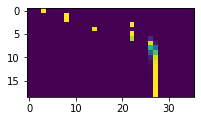

Count 200 | 천안역에서 어떻게 가야하나요? __ => <s>있나요?</s> => None


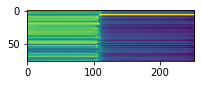

Count 400 | 몇 시까지 영업하나요? __ => 몇시             


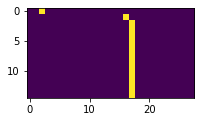

Count 400 | 몇 시까지 영업하나요? __ => <s>아힌나요?</s> => None


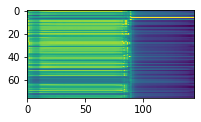

Count 600 | 생일 때문에 가는데 생일 할인을 받을 수 있을까요? ____ => 생일                               


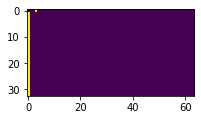

Count 600 | 생일 때문에 가는데 생일 할인을 받을 수 있을까요? ____ => <s>아 있나요?</s> => 아일                               


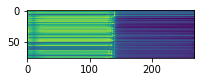

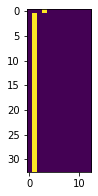

Count 800 | 가장가까운 버스정류장 이름이 뭔가요? __ => 위                      


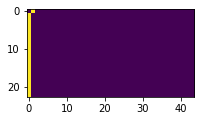

Count 800 | 가장가까운 버스정류장 이름이 뭔가요? __ => <s>아ㅡ 아나요?</s> => None


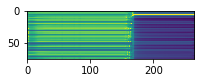

09-26 19:30:52
Mean Train Loss: 0.07604470900026535
Mean Train Seq2Seq Loss: 3.891332495388997
Train CER: 0.9880896411220812
Mean Train Reference Seq2Seq Loss: 3.3745780488671797
Train Reference CER: 0.9464540517283013
Eval Count 50 | 아! 통신사 할인이 적용 되나요? __ => 아녕                   


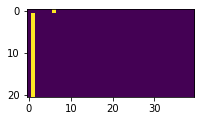

Eval Count 50 | 아! 통신사 할인이 적용 되나요? __ => <s>아느 하나요?</s> => None


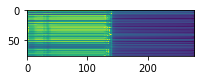

09-26 19:31:10
Mean Evaluation Loss: 0.08098749536388515
Mean Evaluation Seq2Seq Loss: 3.9733711981004287
Evaluation CER: 0.9916932907348243
Mean Evaluation Reference Seq2Seq Loss: 3.2335142681878555
Evaluation Reference CER: 0.9246109950878019


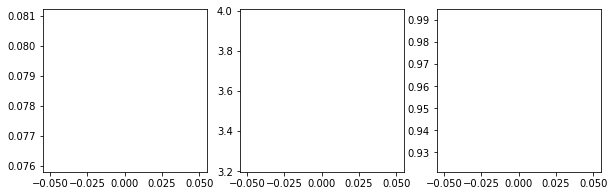

-------------------------------------------------------------------------------------------------------
09-26 19:31:10
Count 200 | 미리 예약 하면 할인 있나요 ___ => 미리                 


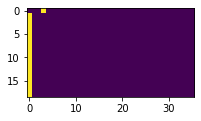

Count 200 | 미리 예약 하면 할인 있나요 ___ => <s>아이 아가요?</s> => None


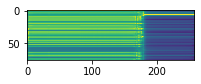

Count 400 | 저녁 7시에 가려고 하는데요 8명 예약가능한가요? _ => 저녁                           


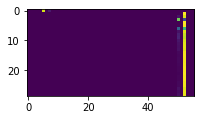

Count 400 | 저녁 7시에 가려고 하는데요 8명 예약가능한가요? _ => <s>아요?</s> => None


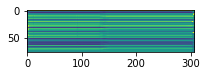

Count 600 | kt는 할인이 얼마나 되나요?  => lgt 인           ?


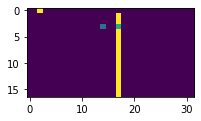

Count 600 | kt는 할인이 얼마나 되나요?  => <s>아나요?</s> => None


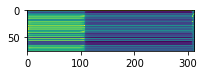

Count 800 | 혹시 예약 시간 변경할 수 있나요~? ___ => 혹시 예약                   


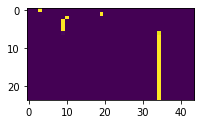

Count 800 | 혹시 예약 시간 변경할 수 있나요~? ___ => <s>았나요?</s> => None


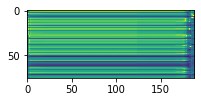

09-26 19:40:37
Mean Train Loss: 0.07489459170285351
Mean Train Seq2Seq Loss: 3.8958369247336493
Train CER: 0.991135028336713
Mean Train Reference Seq2Seq Loss: 2.743626383717442
Train Reference CER: 0.8449632485312585
Eval Count 50 | 만차인데 다른 주차장소 있나요? ____ => 이달          나 ?       


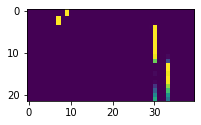

Eval Count 50 | 만차인데 다른 주차장소 있나요? ____ => <s>아ㅚ나요?</s> => None


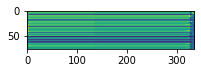

C:\Users\JW\AppData\Local\Continuum\anaconda3\envs\pytorch_env\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\JW\AppData\Local\Continuum\anaconda3\envs\pytorch_env\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


09-26 19:40:53
Mean Evaluation Loss: 0.0863202551460145
Mean Evaluation Seq2Seq Loss: nan
Evaluation CER: 0.0
Mean Evaluation Reference Seq2Seq Loss: 2.477770654867773
Evaluation Reference CER: 0.775162164631361


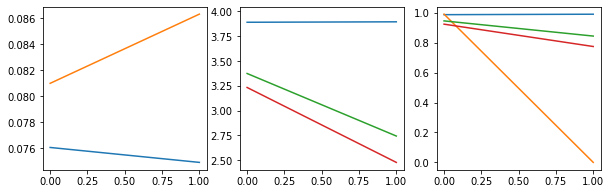

-------------------------------------------------------------------------------------------------------
09-26 19:40:54
Count 200 | 아기가 앉을 수 있는 편안한 의자가 있나요? __ => 아기                         


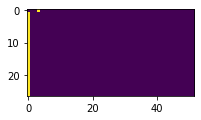

Count 200 | 아기가 앉을 수 있는 편안한 의자가 있나요? __ => <s>ㅇ나요?</s> => None


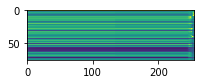

Count 400 | 갑각류가 들어가는 메뉴가 있나요? __ => 남               ?    


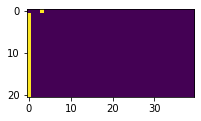

Count 400 | 갑각류가 들어가는 메뉴가 있나요? __ => <s>ㅇ나요?</s> => None


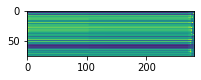

Count 600 | 주차 비용은 어떻게되나요? __ => 주차      떻   나    


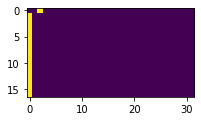

Count 600 | 주차 비용은 어떻게되나요? __ => <s>ㅇㅆ나요?</s> => None


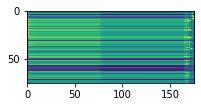

Count 800 | 안녕하세요 이용금액에서 제가 할인받을 수 있는 금액이 얼만지 궁금합니다 __________ => 안녕하세요                                             


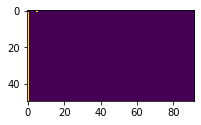

Count 800 | 안녕하세요 이용금액에서 제가 할인받을 수 있는 금액이 얼만지 궁금합니다 __________ => <s>ㅇㅆ나요?</s> => 아                                                 


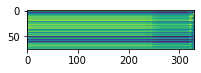

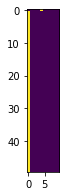

09-26 19:50:28
Mean Train Loss: 0.07996591957974877
Mean Train Seq2Seq Loss: 3.884930791213064
Train CER: 0.9872742464168648
Mean Train Reference Seq2Seq Loss: 2.8251458131856153
Train Reference CER: 0.8532622286960299
Eval Count 50 | 금요일 12시에 예약할 수 있나요? __ => 금요일              나요요  


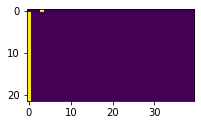

Eval Count 50 | 금요일 12시에 예약할 수 있나요? __ => <s>ㅇㅆ나요?</s> => None


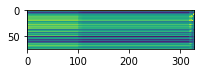

09-26 19:50:45
Mean Evaluation Loss: 0.08166148457178579
Mean Evaluation Seq2Seq Loss: nan
Evaluation CER: 0.0
Mean Evaluation Reference Seq2Seq Loss: 2.569993051668291
Evaluation Reference CER: 0.7805411979325023


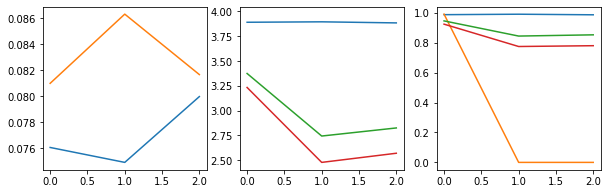

-------------------------------------------------------------------------------------------------------
09-26 19:50:45
Count 200 | 단체 자리 있나요? __ => 단체    있있나요?  


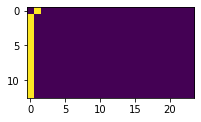

Count 200 | 단체 자리 있나요? __ => <s>있나요?</s> => None


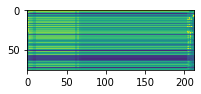

Count 400 | 몇 명 이상 되면 단체 할인 같은 게 있나요? ____ => 몇시부          인       나요?      


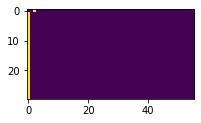

Count 400 | 몇 명 이상 되면 단체 할인 같은 게 있나요? ____ => <s>있나요?</s> => None


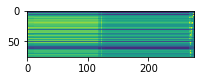

Count 600 | 혹시 애완동물 데리고 갈 수 있나요? _____ => 혹시 아웃백           있나요?     


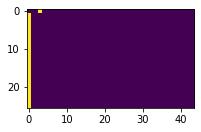

Count 600 | 혹시 애완동물 데리고 갈 수 있나요? _____ => <s>아ㅣㅆ나요?</s> => None


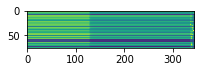

Count 800 | 영업 시작 언제 인가요? ___ => 영업 간간 언제인가요?     


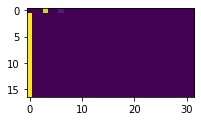

Count 800 | 영업 시작 언제 인가요? ___ => <s>아안나요?</s> => None


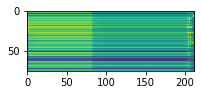

09-26 20:00:21
Mean Train Loss: 0.07506796440423603
Mean Train Seq2Seq Loss: 3.81593184683451
Train CER: 0.9852110582639715
Mean Train Reference Seq2Seq Loss: 2.1384566949821284
Train Reference CER: 0.6801630219388249
Eval Count 50 | 다섯명인데 룸 이용 가능할까요? __ => 명명이      가능한가요?     


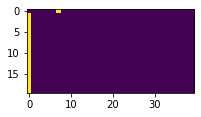

Eval Count 50 | 다섯명인데 룸 이용 가능할까요? __ => <s>아인나요?</s> => None


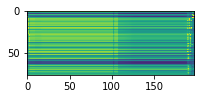

09-26 20:00:38
Mean Evaluation Loss: 0.08485960838358822
Mean Evaluation Seq2Seq Loss: 4.140663617843524
Evaluation CER: 0.997158193874329
Mean Evaluation Reference Seq2Seq Loss: 2.089973957928934
Evaluation Reference CER: 0.6321011266174581


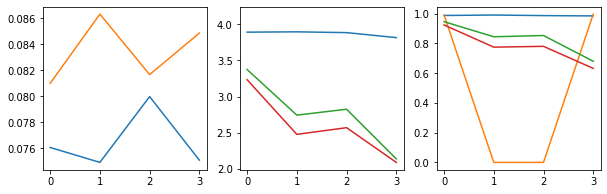

-------------------------------------------------------------------------------------------------------
09-26 20:00:38
Count 200 | 지금 가는중인데 10분뒤에 예약할 수 있나요? _ => 지금 1시                있나나?  


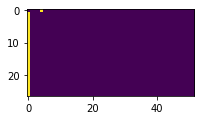

Count 200 | 지금 가는중인데 10분뒤에 예약할 수 있나요? _ => <s>아ㅣㅆ나요?</s> => None


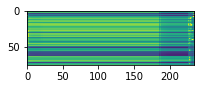

Count 400 | 번호좀 확인할게요 _____ => 설촌  할할해해요요     


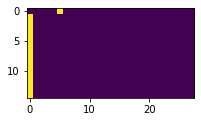

Count 400 | 번호좀 확인할게요 _____ => <s>아인나요?</s> => None


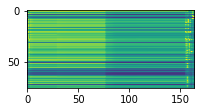

Count 600 | 안녕하세요 아웃백 원주점 맞나요? ___ => 안녕하세요 아웃백 매장에  맞맞나요?? 


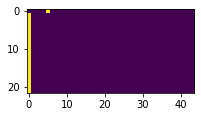

Count 600 | 안녕하세요 아웃백 원주점 맞나요? ___ => <s>아인나요?</s> => None


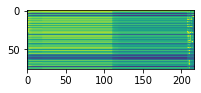

Count 800 | 오늘 저녁에 갔었는데요 혹시 검은색 가방 없나요? 보관하는데가 따로 있나요? _______ => 오늘 저녁                                  나          


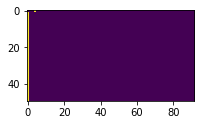

Count 800 | 오늘 저녁에 갔었는데요 혹시 검은색 가방 없나요? 보관하는데가 따로 있나요? _______ => <s>아있나요?</s> => 아                                                 


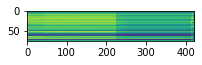

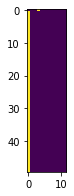

09-26 20:10:08
Mean Train Loss: 0.07380442901297311
Mean Train Seq2Seq Loss: 3.7875428076638604
Train CER: 0.982094496566399
Mean Train Reference Seq2Seq Loss: 1.680925307861328
Train Reference CER: 0.5766214002688355
Eval Count 50 | 여름시즌 행사 있나요? __ => 여러  행행사 있나요?   


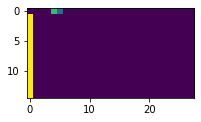

Eval Count 50 | 여름시즌 행사 있나요? __ => <s>아인나요?</s> => None


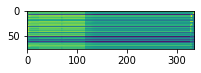

09-26 20:10:25
Mean Evaluation Loss: 0.07999528225329892
Mean Evaluation Seq2Seq Loss: 4.173631237399194
Evaluation CER: 0.9987096774193548
Mean Evaluation Reference Seq2Seq Loss: 1.738641382157621
Evaluation Reference CER: 0.5275234994163543


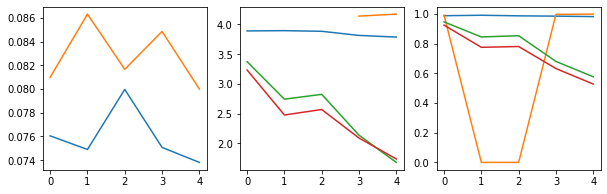

-------------------------------------------------------------------------------------------------------
09-26 20:10:26
Count 200 | 메뉴 주문 미리할 수 있을까요? _ => 메뉴 주문 미리      을까요? 


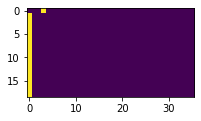

Count 200 | 메뉴 주문 미리할 수 있을까요? _ => <s>아ㅣㅆ나요?</s> => None


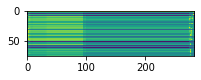

Count 400 | 랍스터 판매중인가요? ___ => 랍스터 판매인인가요?    


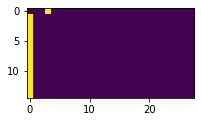

Count 400 | 랍스터 판매중인가요? ___ => <s>자있나요?</s> => None


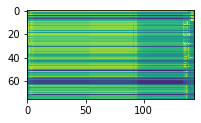

Count 600 | 여름방학에 특별 메뉴가 나오는걸로 아는데 뭐가 있나요? __ => 여름 세트                가 가 있있나요    


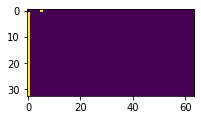

Count 600 | 여름방학에 특별 메뉴가 나오는걸로 아는데 뭐가 있나요? __ => <s>아인나요?</s> => 아                         요      


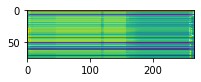

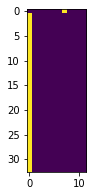

Count 800 | 오후에 주차 몇 시간까지 가능한가요? __ => 오후 주주  몇시까지지 가능한가요?    


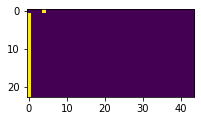

Count 800 | 오후에 주차 몇 시간까지 가능한가요? __ => <s>아인가요?</s> => None


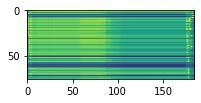

09-26 20:20:00
Mean Train Loss: 0.07328196700352241
Mean Train Seq2Seq Loss: 3.7353651589459416
Train CER: 0.9759266093741762
Mean Train Reference Seq2Seq Loss: 1.4060144794208418
Train Reference CER: 0.5084804202546213
Eval Count 50 | 몇시부터 몇시까지하세요? _ => 몇시시터  시까시시하요?  


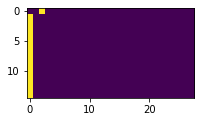

Eval Count 50 | 몇시부터 몇시까지하세요? _ => <s>아인나요?</s> => None


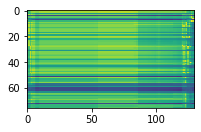

09-26 20:20:16
Mean Evaluation Loss: 0.07887404755644312
Mean Evaluation Seq2Seq Loss: 4.129478915112925
Evaluation CER: 0.9865119196988708
Mean Evaluation Reference Seq2Seq Loss: 1.6051529259321144
Evaluation Reference CER: 0.5196914948531868


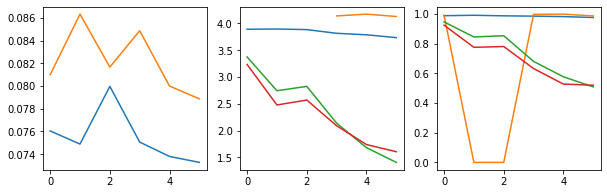

-------------------------------------------------------------------------------------------------------
09-26 20:20:17
Count 200 | 예약하려고 하는데요 __ => 예약하려고 하는데요   


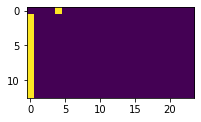

Count 200 | 예약하려고 하는데요 __ => <s>아있나요?</s> => None


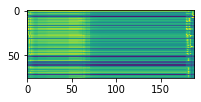

Count 400 | 단체석은 몇인까지 가능한가요? _____ => 단체는 몇 까까지 가능한가요?      


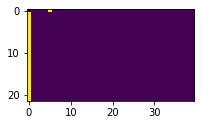

Count 400 | 단체석은 몇인까지 가능한가요? _____ => <s>앙있나요?</s> => None


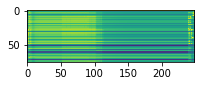

Count 600 | 그럼 투움바파스타 세 개하고 과일에이드 3잔 주문할게요 __ => 그러  이                     요요요요   


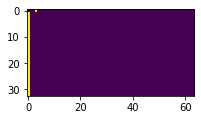

Count 600 | 그럼 투움바파스타 세 개하고 과일에이드 3잔 주문할게요 __ => <s>아이나요?</s> => 네                         요      


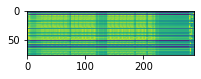

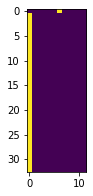

Count 800 | 학생할인은 얼마나되요? ____ => 학생할인은 얼마나요요?     


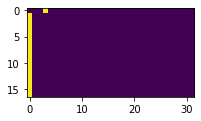

Count 800 | 학생할인은 얼마나되요? ____ => <s>앙아나요?</s> => None


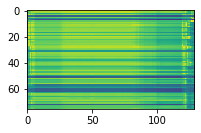

09-26 20:29:58
Mean Train Loss: 0.07194440960913076
Mean Train Seq2Seq Loss: 3.73050405703934
Train CER: 0.9682166997001576
Mean Train Reference Seq2Seq Loss: 1.1590511887336958
Train Reference CER: 0.44921103456732814
Eval Count 50 | 혹시 베이비시트 사용 가능한가요? __ => 혹시 이이 이 식  가능한가요?    


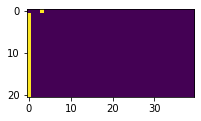

Eval Count 50 | 혹시 베이비시트 사용 가능한가요? __ => <s>앙이나요?</s> => None


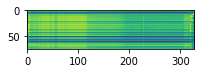

09-26 20:30:15
Mean Evaluation Loss: 0.08013209314116815
Mean Evaluation Seq2Seq Loss: 4.211299866595226
Evaluation CER: 0.9876308277830638
Mean Evaluation Reference Seq2Seq Loss: 1.432052388253771
Evaluation Reference CER: 0.47033911123211425


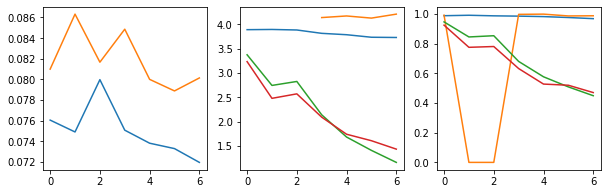

-------------------------------------------------------------------------------------------------------
09-26 20:30:15
Count 200 | 보통 라스트 오더는 몇시까지 가능한가요? _____ => 보통 토마스  더는 몇시까지 가능한가요?      


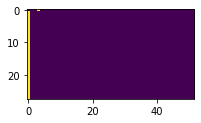

Count 200 | 보통 라스트 오더는 몇시까지 가능한가요? _____ => <s>앙이나요?</s> => None


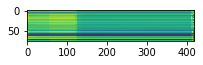

Count 400 | 할인은 어떻게 받을 수 있나요? ___ => 할인은 어떻게 받을 수 있나요?    


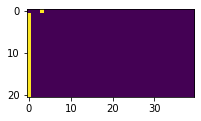

Count 400 | 할인은 어떻게 받을 수 있나요? ___ => <s>앙이나요?</s> => None


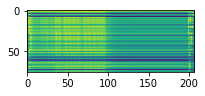

Count 600 | 오늘 몇 시까지 영업해요? __ => 오늘 몇 시까지 영업해요?   


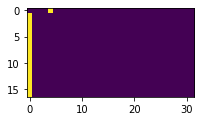

Count 600 | 오늘 몇 시까지 영업해요? __ => <s>앙히나요?</s> => None


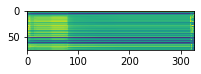

Count 800 | 위 모든 질문에 해당하지 않는 '할인'과 관련한 자유로운 질문을 해주세요 ____ => 위 모든 질문    하   ' ' '              해주세주       


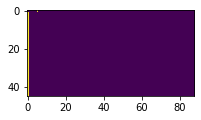

Count 800 | 위 모든 질문에 해당하지 않는 '할인'과 관련한 자유로운 질문을 해주세요 ____ => <s>안이나요?</s> => 제녕                                           


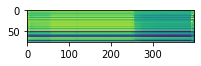

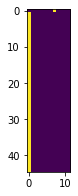

09-26 20:39:51
Mean Train Loss: 0.07243780741452291
Mean Train Seq2Seq Loss: 3.761411157941391
Train CER: 0.98065661797349
Mean Train Reference Seq2Seq Loss: 0.9953573355030049
Train Reference CER: 0.4033557002640428
Eval Count 50 | 공휴일에는 몇 시까지 영업하세요? ___ => 공휴일에는 몇시시까지 영업하세요?    


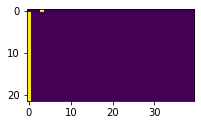

Eval Count 50 | 공휴일에는 몇 시까지 영업하세요? ___ => <s>앙아나요?</s> => None


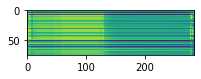

09-26 20:40:08
Mean Evaluation Loss: 0.07589335392865083
Mean Evaluation Seq2Seq Loss: 4.198798659726438
Evaluation CER: 0.9829212337496813
Mean Evaluation Reference Seq2Seq Loss: 1.326218124902181
Evaluation Reference CER: 0.44775311315646993


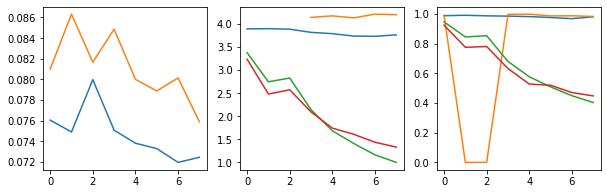

-------------------------------------------------------------------------------------------------------
09-26 20:40:08
Count 200 | 연어 스테이크 먹고 싶은데 메뉴 아직도 파세요?  => 연  스테이크  고고싶싶은     도 도 파나요?


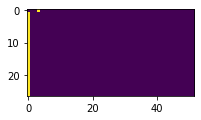

Count 200 | 연어 스테이크 먹고 싶은데 메뉴 아직도 파세요?  => <s>앙이나요?</s> => None


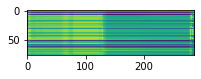

Count 400 | 발레파킹 서비스되나요? _ => 발레파킹 비스 되나나요? 


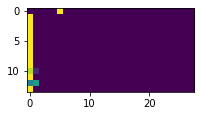

Count 400 | 발레파킹 서비스되나요? _ => <s>아으있나요?</s> => None


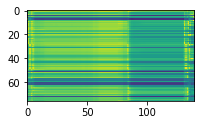

Count 600 | 매장과 가까운 주차장은 어디인가요? ______ => 매장  주주주차장   어인인가요?        


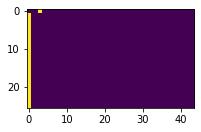

Count 600 | 매장과 가까운 주차장은 어디인가요? ______ => <s>아ㅣㅡ았나요?</s> => None


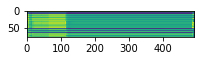

Count 800 | 안녕하세요 포장 예약을 하고 싶은데요 혹시 투움바 파스타도 포장이 가능한가요? _____ => 안녕하세요 제가 예약 예약을 싶싶싶데데       파 파          가가가요요 요 


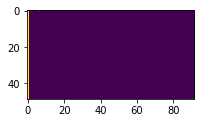

Count 800 | 안녕하세요 포장 예약을 하고 싶은데요 혹시 투움바 파스타도 포장이 가능한가요? _____ => <s>아니ㅡ 한나요?</s> => 위                                                


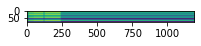

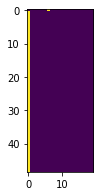

09-26 20:49:46
Mean Train Loss: 0.07074529194207188
Mean Train Seq2Seq Loss: 3.7387117023106318
Train CER: 0.9686943796226714
Mean Train Reference Seq2Seq Loss: 1.000096727798455
Train Reference CER: 0.4068021269265122
Eval Count 50 | 오늘은 몇 시에 닫아요? _ => 오늘 몇 시에  닫아요?  


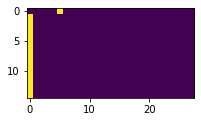

Eval Count 50 | 오늘은 몇 시에 닫아요? _ => <s>아ㅣ 인나요?</s> => None


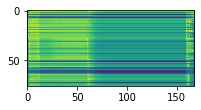

09-26 20:50:03
Mean Evaluation Loss: 0.07690565012406826
Mean Evaluation Seq2Seq Loss: 4.174281825876345
Evaluation CER: 0.9991546914623838
Mean Evaluation Reference Seq2Seq Loss: 1.308517964964628
Evaluation Reference CER: 0.42215660946054007


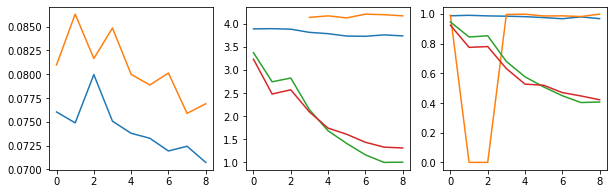

-------------------------------------------------------------------------------------------------------
09-26 20:50:04
Count 200 | 6시 30분으로 예약했는데 7시로 변경해주세요 __ => 6시 30로 예약예약했는데 시로 로   해주세요  


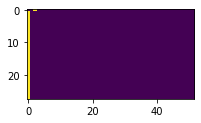

Count 200 | 6시 30분으로 예약했는데 7시로 변경해주세요 __ => <s>아ㅣㅡ아나요?</s> => None


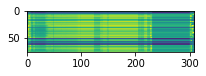

Count 400 | 아웃백 원주점 맞죠? ___ => 아웃백 죽전점 맞죠?    


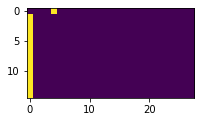

Count 400 | 아웃백 원주점 맞죠? ___ => <s>자ㅣㅣ 이나요?</s> => None


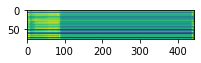

Count 600 | 치킨 텐더 샐러드 하나 포장해주세요 ___ => 치킨 텐더 샐러드드    해주주요요요   


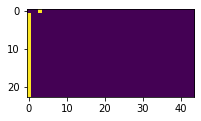

Count 600 | 치킨 텐더 샐러드 하나 포장해주세요 ___ => <s>아ㅣㅣ 아나요?</s> => None


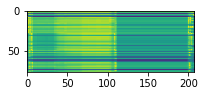

Count 800 | 지금 한 10명 정도 가고 있는데 같은 자리에 앉도록 상을 붙여 주실 수 있나요? ____ => 지금 4명동에       는는데                                 


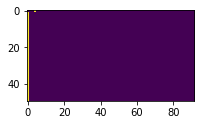

Count 800 | 지금 한 10명 정도 가고 있는데 같은 자리에 앉도록 상을 붙여 주실 수 있나요? ____ => <s>아이ㅡ 있나요?</s> => 위  든                                              


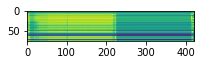

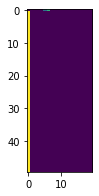

09-26 20:59:44
Mean Train Loss: 0.06957640449554904
Mean Train Seq2Seq Loss: 3.7716331567805432
Train CER: 0.979109795695526
Mean Train Reference Seq2Seq Loss: 1.032230353326457
Train Reference CER: 0.41454109631138547
Eval Count 50 | 점심시간이언제이지요? ___ => 점심시간이 언제지요?    


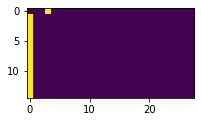

Eval Count 50 | 점심시간이언제이지요? ___ => <s>아이ㅡ 있나요?</s> => None


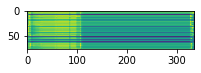

09-26 21:00:01
Mean Evaluation Loss: 0.07538617335665015
Mean Evaluation Seq2Seq Loss: 4.178635135773689
Evaluation CER: 0.9958226221079691
Mean Evaluation Reference Seq2Seq Loss: 1.3599540246998805
Evaluation Reference CER: 0.4389205415671139


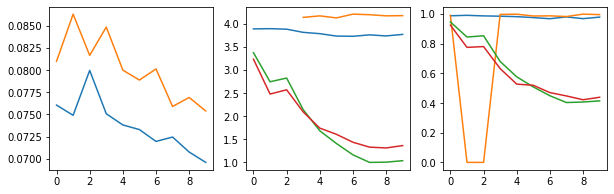

-------------------------------------------------------------------------------------------------------
09-26 21:00:01
Count 200 | 혹시 아메리칸 익스프레스도 할인 가능한가요? __ => 혹시 메리        할 인  가능한가요?   


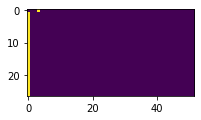

Count 200 | 혹시 아메리칸 익스프레스도 할인 가능한가요? __ => <s>아이ㅣㅇ인나요?</s> => None


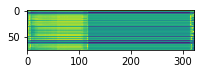

Count 400 | 가까운 건물 이름이 무엇인가요? ___ => 가운운 건물 이름이 무엇인가요?    


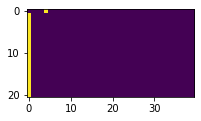

Count 400 | 가까운 건물 이름이 무엇인가요? ___ => <s>아이ㅣ이나요?</s> => None


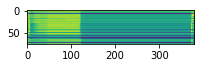

Count 600 | 단체 할인이 따로 있나요? _ => 단체 할인이 따로 있나요?  


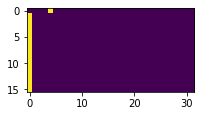

Count 600 | 단체 할인이 따로 있나요? _ => <s>아아있나요?</s> => None


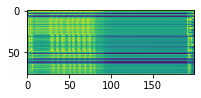

Count 800 | 전화로만 예약이 가능한가요? 앱으로도 예약할 수 있나요? 예약 방법 알려주세요 ______ => 전화로  예약  능한능       예      로  로          세 세       


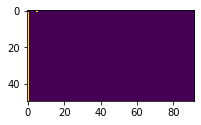

Count 800 | 전화로만 예약이 가능한가요? 앱으로도 예약할 수 있나요? 예약 방법 알려주세요 ______ => <s>아인나요?</s> => 아                                                 


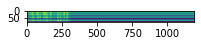

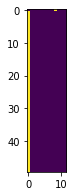

09-26 21:09:46
Mean Train Loss: 0.06857406072436832
Mean Train Seq2Seq Loss: 3.784864798217741
Train CER: 0.9729621177544501
Mean Train Reference Seq2Seq Loss: 1.0243506636476571
Train Reference CER: 0.41139348643225765
Eval Count 50 | 제니님 지금 통화 가능하신가요? ____ => 제일  님님과 통통 가능한가요?     


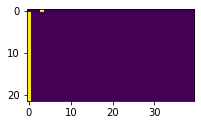

Eval Count 50 | 제니님 지금 통화 가능하신가요? ____ => <s>ㅇ아나요?</s> => None


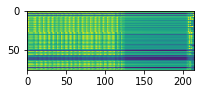

09-26 21:10:03
Mean Evaluation Loss: 0.07722967607856152
Mean Evaluation Seq2Seq Loss: 4.074646418706025
Evaluation CER: 0.9951053415620345
Mean Evaluation Reference Seq2Seq Loss: 1.551232699104812
Evaluation Reference CER: 0.4864428958339673


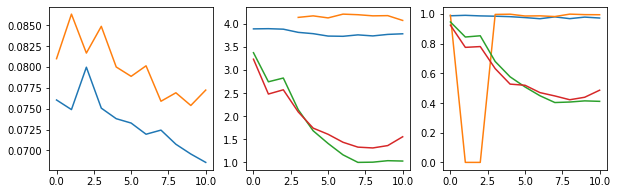

-------------------------------------------------------------------------------------------------------
09-26 21:10:03
Count 200 | 주차비 얼마인가요? __ => 주차비 얼마인가요?   


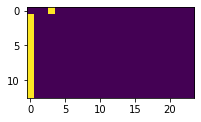

Count 200 | 주차비 얼마인가요? __ => <s>자히나요?</s> => None


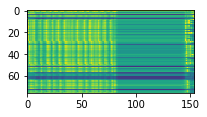

Count 400 | 신한 러브카드 가지고 있는데 할인 몇프로 되요? __ => 신한카드  프로 가가  는데        되되요?  


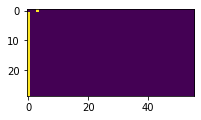

Count 400 | 신한 러브카드 가지고 있는데 할인 몇프로 되요? __ => <s>아이나요?</s> => 지체                           


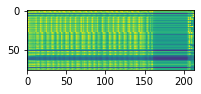

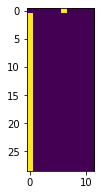

Count 600 | 토요일 영업시간이 언제까지인가요? ____ => 토요일 영업시간이 언제까지인가요?     


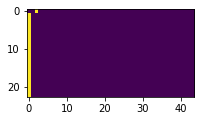

Count 600 | 토요일 영업시간이 언제까지인가요? ____ => <s>아앙아ㅏ이나요?</s> => None


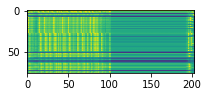

Count 800 | 당일예약이 가능한가요? ____ => 당일예약이 가능한가요?     


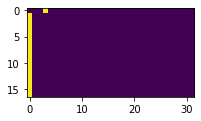

Count 800 | 당일예약이 가능한가요? ____ => <s>앙앙ㅇㅇㅇ있나요?</s> => None


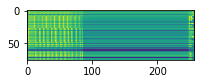

09-26 21:20:00
Mean Train Loss: 0.0685412749576802
Mean Train Seq2Seq Loss: 3.7173508473402133
Train CER: 0.9732841833244661
Mean Train Reference Seq2Seq Loss: 0.9975272768967725
Train Reference CER: 0.40250445258029505
Eval Count 50 | 통신사 할인도 되나요? __ => 통신사 할인도 되나요?   


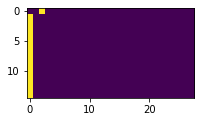

Eval Count 50 | 통신사 할인도 되나요? __ => <s>아이ㅣㅣㅇㅇ아이인나요?</s> => None


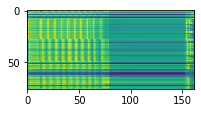

09-26 21:20:17
Mean Evaluation Loss: 0.074127717355085
Mean Evaluation Seq2Seq Loss: 4.224012691693108
Evaluation CER: 0.9896691121425363
Mean Evaluation Reference Seq2Seq Loss: 1.328818031642537
Evaluation Reference CER: 0.43010422110861746


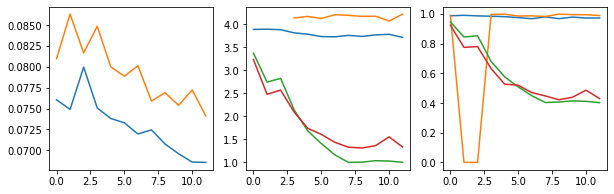

-------------------------------------------------------------------------------------------------------
09-26 21:20:18
Count 200 | 예약하는 김에 메뉴주문까지 해두려는데 되나요? _ => 예약시간    미리 주주하하는  해해 되되요요? 


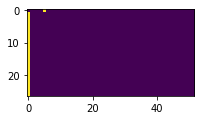

Count 200 | 예약하는 김에 메뉴주문까지 해두려는데 되나요? _ => <s>앙아ㅏㅇㅇ앙ㅇ이나요?</s> => 아                          


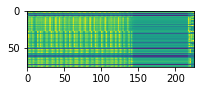

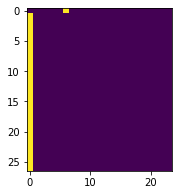

Count 400 | 영업시간 언제인가요? ___ => 영업시간 언제인가요?    


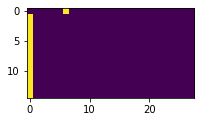

Count 400 | 영업시간 언제인가요? ___ => <s>앙아ㅣㅇ아 이나요?</s> => None


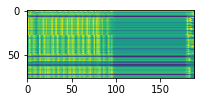

Count 600 | 주중과 주말 영업시간이 어떻게되나요? ___ => 주중과 주주말영영업시간이어떻게되나요?    


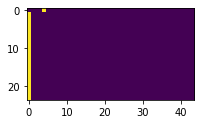

Count 600 | 주중과 주말 영업시간이 어떻게되나요? ___ => <s>아이아ㅏㅇ이이이이아 이나요?</s> => None


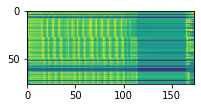

Count 800 | 안녕하세요 영업시간 관련해서 문의드립니다 주말에는 몇 시에 오픈하시나요? _________ => 안녕하세요 영업시간  문해서    몇   몇     시 시 하시나나요            


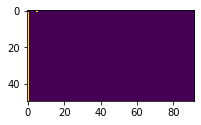

Count 800 | 안녕하세요 영업시간 관련해서 문의드립니다 주말에는 몇 시에 오픈하시나요? _________ => <s>ㅇㅇ이나요?</s> => 위치 세요                                    요        


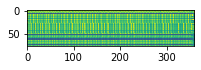

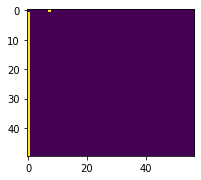

09-26 21:30:22
Mean Train Loss: 0.06634257742116086
Mean Train Seq2Seq Loss: 3.6629064424057045
Train CER: 0.9518037205333623
Mean Train Reference Seq2Seq Loss: 0.840870188149008
Train Reference CER: 0.3611701567001616
Eval Count 50 | 그렇군요 그럼 혹시 아기용 수저가 따로 있나요? ______ => 그럼군  쉬   아아            따로 나나??   


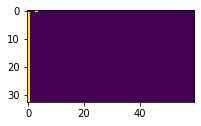

Eval Count 50 | 그렇군요 그럼 혹시 아기용 수저가 따로 있나요? ______ => <s>아ㅏㅏㅏㅣㅏㅏㅏㅏ 히나요?</s> => 죄송                               


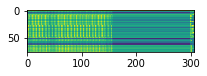

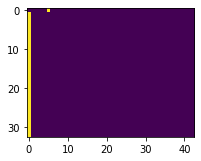

09-26 21:30:39
Mean Evaluation Loss: 0.07315471857684479
Mean Evaluation Seq2Seq Loss: 4.071178824554324
Evaluation CER: 0.9987293519695044
Mean Evaluation Reference Seq2Seq Loss: 1.2928591294581002
Evaluation Reference CER: 0.41202025346795695


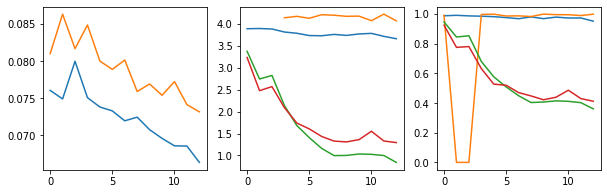

-------------------------------------------------------------------------------------------------------
09-26 21:30:40
Count 200 | 파스타 포장주문을 하고 싶은데 가능한가요? ___ => 파스타 포장 주문하고은싶은데 가능한가요?     


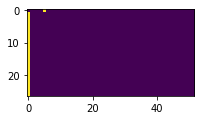

Count 200 | 파스타 포장주문을 하고 싶은데 가능한가요? ___ => <s>아이나요?</s> => None


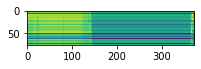

Count 400 | 유스퀘어에서 몇분 정도 걸리나요? _ => 쉬스퀘에서 몇 정정도 걸리나나??  


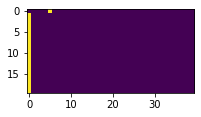

Count 400 | 유스퀘어에서 몇분 정도 걸리나요? _ => <s>아 이나요?</s> => None


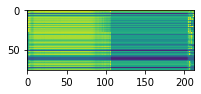

Count 600 | 1월 1일에도 영업 하나요?  => 1월 1일에도 영업 하나요? 


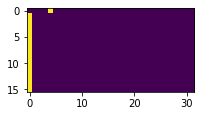

Count 600 | 1월 1일에도 영업 하나요?  => <s>아 이나요?</s> => None


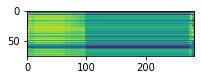

Count 800 | 토마호크 스테이크 1개랑 투움바 파스타 1개 주문 해주세요 음료는 가서 주문해도 되죠? _ => 토마호크 스테이크 미리  투움  바파타                 주문문         


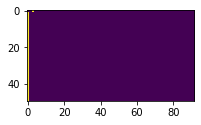

Count 800 | 토마호크 스테이크 1개랑 투움바 파스타 1개 주문 해주세요 음료는 가서 주문해도 되죠? _ => <s>자이ㅣㅣㅣㅇ시아아아아아ㅏ아아아아아이아ㅏㅏ아아아ㅏ이ㅣ 이나요?</s> => 제가                                                


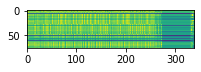

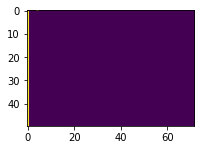

09-26 21:40:20
Mean Train Loss: 0.0705644437622493
Mean Train Seq2Seq Loss: 3.696028774781916
Train CER: 0.9617821175493907
Mean Train Reference Seq2Seq Loss: 0.7636323906452862
Train Reference CER: 0.3412737603781908
Eval Count 50 | 생일자가 있다면 다른 서비스 혹시 있어요? ____ => 생일자 가려면  다른     혹시시어어요?     


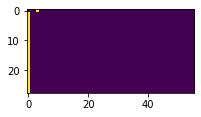

Eval Count 50 | 생일자가 있다면 다른 서비스 혹시 있어요? ____ => <s>아 이나요?</s> => None


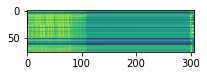

09-26 21:40:38
Mean Evaluation Loss: 0.09492538425855093
Mean Evaluation Seq2Seq Loss: nan
Evaluation CER: 0.0
Mean Evaluation Reference Seq2Seq Loss: 1.1649084874717517
Evaluation Reference CER: 0.3823470122390209


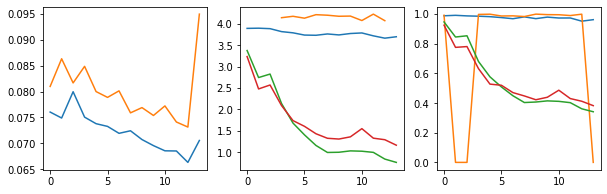

-------------------------------------------------------------------------------------------------------
09-26 21:40:39
Count 200 | 오늘 저녁에 가려고 하는데 예약 가능할까요? __ => 오늘 저녁에 가려고하하는데 예약 가능할까요?   


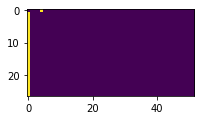

Count 200 | 오늘 저녁에 가려고 하는데 예약 가능할까요? __ => <s>아아아아ㅏ아아아아아아히나요?</s> => None


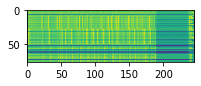

Count 400 | 오늘 영업 시간이 언제부터인가요? __ => 오늘 영업 시간이 언제부터인가요?   


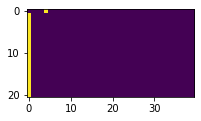

Count 400 | 오늘 영업 시간이 언제부터인가요? __ => <s>앙이이아아아아아이나요?</s> => None


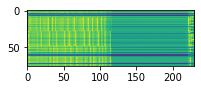

Count 600 | 지금 예약 할 수 있나요? _ => 지금 예약할 수 있나요?   


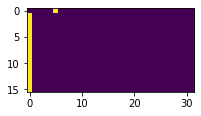

Count 600 | 지금 예약 할 수 있나요? _ => <s>아아이아아아아아이나요?</s> => None


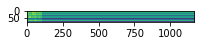

Count 800 | 안녕하세요 영업시간 관련해서 문의드립니다 주말에는 몇 시에 오픈하시나요? _________ => 안녕하세요 영업시간에관관해서    립          시 시 시   나나나나??      


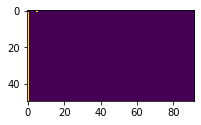

Count 800 | 안녕하세요 영업시간 관련해서 문의드립니다 주말에는 몇 시에 오픈하시나요? _________ => <s>아아아아아ㅣ아아아아아아아아아아아이나요?</s> => 위녕 든                                              


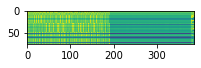

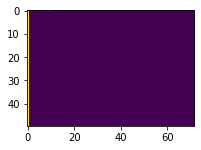

09-26 21:50:50
Mean Train Loss: 0.0656328442544759
Mean Train Seq2Seq Loss: 3.651483130138763
Train CER: 0.9458327765156577
Mean Train Reference Seq2Seq Loss: 0.7547364812688553
Train Reference CER: 0.3389166962256467
Eval Count 50 | skt멤버쉽할인 되나요? __ => skt는 할인인되되나요?   


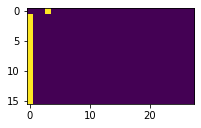

Eval Count 50 | skt멤버쉽할인 되나요? __ => <s>아 아나요?</s> => None


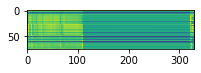

09-26 21:51:06
Mean Evaluation Loss: 0.10656250729046118
Mean Evaluation Seq2Seq Loss: nan
Evaluation CER: 0.0
Mean Evaluation Reference Seq2Seq Loss: 1.3101885854336532
Evaluation Reference CER: 0.43815232936737364


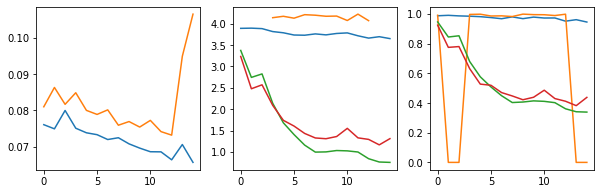

-------------------------------------------------------------------------------------------------------
09-26 21:51:06
Count 200 | 아웃백 위치가 어떻게 되나요? _ => 아웃백 위치가 어떻게 되나요?  


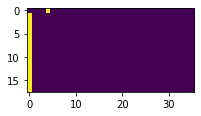

Count 200 | 아웃백 위치가 어떻게 되나요? _ => <s>아ㅏ아이이아아아 이나요?</s> => None


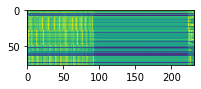

Count 400 | 서빙하는 사람 교육 다시 시켜야 하는거 아니에요?  => 서빙하 다사람 육육 시  시켜켜야 는거거 아요요요 


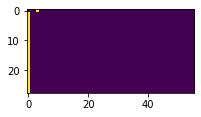

Count 400 | 서빙하는 사람 교육 다시 시켜야 하는거 아니에요?  => <s>아ㅣ아아아ㅏ아이이앙아ㅏ 이나요?</s> => 지일                     요요   


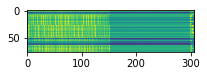

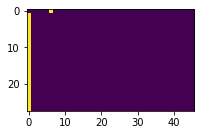

Count 600 | 공휴일에 영업하시나요~? ____ => 공휴일에 영업하시나요~?     


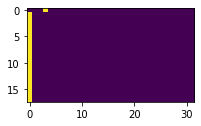

Count 600 | 공휴일에 영업하시나요~? ____ => <s>아ㅣ이이아아이이나요?</s> => None


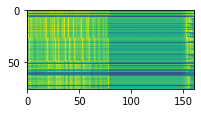

Count 800 | 구로역에서 지하철타면 몇 분 걸리나요 __ => 구로역에서 지하면  면  분 리나요요   


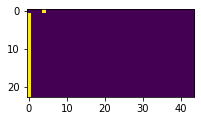

Count 800 | 구로역에서 지하철타면 몇 분 걸리나요 __ => <s>*아이아아는이나요?</s> => None


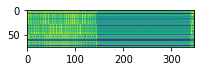

09-26 22:01:20
Mean Train Loss: 0.06469590948449286
Mean Train Seq2Seq Loss: 3.6700227706828032
Train CER: 0.9523401074629791
Mean Train Reference Seq2Seq Loss: 0.672637457972162
Train Reference CER: 0.3139346422453551
Eval Count 50 | 학교 단체 도시락 메뉴 있을까요? _ => 학생  모체  메리  있 있을요?  


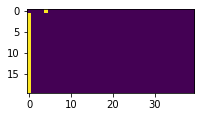

Eval Count 50 | 학교 단체 도시락 메뉴 있을까요? _ => <s>아이ㅣ이나요?</s> => None


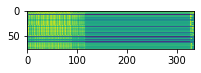

09-26 22:01:37
Mean Evaluation Loss: 0.07359134137513337
Mean Evaluation Seq2Seq Loss: 4.087199607787178
Evaluation CER: 0.9979249198264478
Mean Evaluation Reference Seq2Seq Loss: 1.0495872070758314
Evaluation Reference CER: 0.36408405469060656


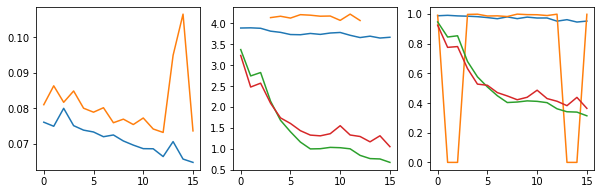

-------------------------------------------------------------------------------------------------------
09-26 22:01:37
Count 200 | 거기가 강남역 1번 출구에서 어느 방향이죠? __ => 거기가 강남역 1번 출구에서 어느  향가까죠?  


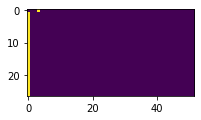

Count 200 | 거기가 강남역 1번 출구에서 어느 방향이죠? __ => <s>ㅇ앙아아아아ㅏ아아이나요?</s> => 아웃  요                      


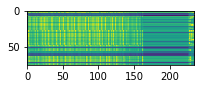

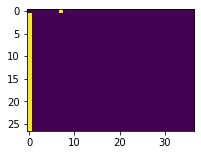

Count 400 | 자가용 끌고 가도 되나요?  => 자가용 끌고 가도 되나요? 


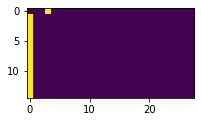

Count 400 | 자가용 끌고 가도 되나요?  => <s>아ㅏ아아아아 이나요?</s> => None


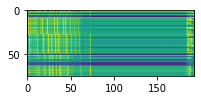

Count 600 | 이번주말에 단체예약하려고 하는데요 ____ => 이번주말에 단체예예약하려고 하는데요    


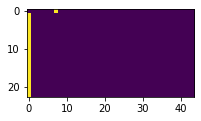

Count 600 | 이번주말에 단체예약하려고 하는데요 ____ => <s>아아아이앙이이아아ㅏ가 아나요?</s> => None


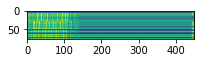

Count 800 | 다음주 월요일 4시에 10명 예약했는데 혹시 13명으로 인원 변경이 가능한가요? _____ => 다음  토요일 토요에  에명  약           경 경경경경경 경  가가요요요     


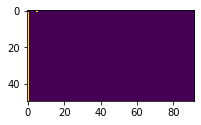

Count 800 | 다음주 월요일 4시에 10명 예약했는데 혹시 13명으로 인원 변경이 가능한가요? _____ => <s>아이아아이이아이아아아아아이아잉아아아아아아아 이나요?</s> => 안  세                                              


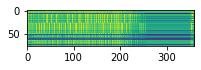

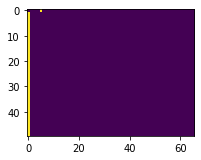

09-26 22:11:49
Mean Train Loss: 0.06371566347123431
Mean Train Seq2Seq Loss: 3.662650109948869
Train CER: 0.9553147543927919
Mean Train Reference Seq2Seq Loss: 0.7020945289192684
Train Reference CER: 0.32642843828466794
Eval Count 50 | 터미널 버스정류장에서 걸어가면 얼마나 걸리나요? ___ => 터미스트 트류장 서 서 얼얼마마나나 리나요??     


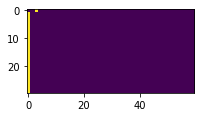

Eval Count 50 | 터미널 버스정류장에서 걸어가면 얼마나 걸리나요? ___ => <s>자가가ㅏ가이나요?</s> => 전가하                           


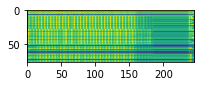

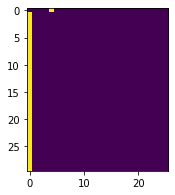

09-26 22:12:07
Mean Evaluation Loss: 0.07163980138920872
Mean Evaluation Seq2Seq Loss: 4.141781884433648
Evaluation CER: 0.984023475709162
Mean Evaluation Reference Seq2Seq Loss: 1.3391027236389643
Evaluation Reference CER: 0.4621332932149842


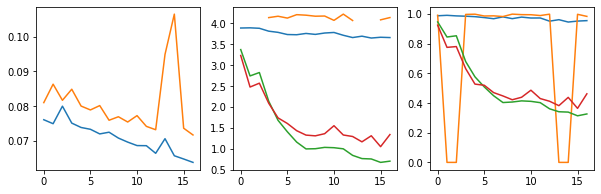

-------------------------------------------------------------------------------------------------------
09-26 22:12:07
Count 200 | 설날 당일 4명 창가자리 예약 가능한가요? ___ => 설날 당일  명 창가자리 예능가가한요요?     


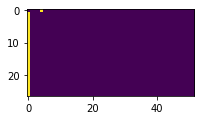

Count 200 | 설날 당일 4명 창가자리 예약 가능한가요? ___ => <s>아아이이아아아아시시이아가 이나요?</s> => 혹시                         


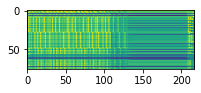

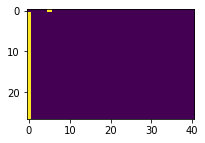

Count 400 | 주말에는 보통 얼마나 기다리나요? ___ => 주말에는 보통 얼마나 기다리나요?    


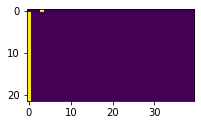

Count 400 | 주말에는 보통 얼마나 기다리나요? ___ => <s>아아이아아아시아ㅏ아ㅏ이나 이나요?</s> => None


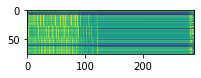

Count 600 | 창가 자리로 예약해주세요 ___ => 창가 자리로 예약해주세요    


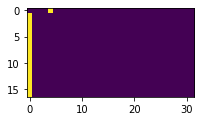

Count 600 | 창가 자리로 예약해주세요 ___ => <s>아ㅏ아아아ㅏ 이나요?</s> => None


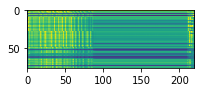

Count 800 | 죄송한데  멤버십 카드를 분실했는데 주민번호로 멤버십 번호 조회 가능한지요? _______ => 죄송한데 멤버십를  주로    는는데   민민민  멤멤십           ????    


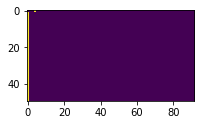

Count 800 | 죄송한데  멤버십 카드를 분실했는데 주민번호로 멤버십 번호 조회 가능한지요? _______ => <s>아아아이아아이ㅏ아이아이이아아아아아ㅏ아나회나요?</s> => 위녕 세                                              


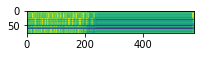

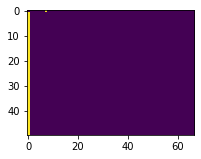

09-26 22:22:24
Mean Train Loss: 0.06312432753049563
Mean Train Seq2Seq Loss: 3.6623855197544355
Train CER: 0.9505467611813957
Mean Train Reference Seq2Seq Loss: 0.6963651391850783
Train Reference CER: 0.3207981547280704
Eval Count 50 | 생일자가 있다면 다른 서비스 혹시 있어요? ______ => 생일파  가면  다른        시어어?       


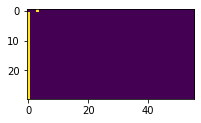

Eval Count 50 | 생일자가 있다면 다른 서비스 혹시 있어요? ______ => <s>아하나요?</s> => 안                             


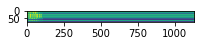

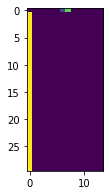

09-26 22:22:42
Mean Evaluation Loss: 0.08236632910959078
Mean Evaluation Seq2Seq Loss: 4.018595932469224
Evaluation CER: 0.9890745501285347
Mean Evaluation Reference Seq2Seq Loss: 0.9310452783592486
Evaluation Reference CER: 0.3547540403444615


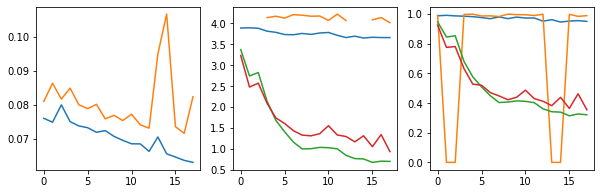

-------------------------------------------------------------------------------------------------------
09-26 22:22:43
Count 200 | 아기 전용 의자가 있는 자리 예약가능한가요 ____ => 아기 전용 자자가 자는 자리 예약가가요       


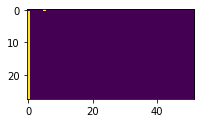

Count 200 | 아기 전용 의자가 있는 자리 예약가능한가요 ____ => <s>아시이ㅏ아이이이아아나 이나요?</s> => 아기                          


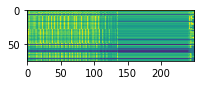

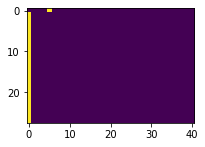

Count 400 | 할인은 어떻게 받을 수 있나요? ____ => 할인은 어떻게 받을 수 있나요?     


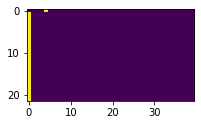

Count 400 | 할인은 어떻게 받을 수 있나요? ____ => <s>아이아이이이이시 이나요?</s> => None


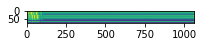

Count 600 | 마지막 오더가 몇시인가요? __ => 마지막 오더가 몇시인인요?   


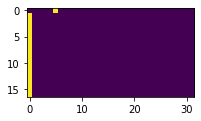

Count 600 | 마지막 오더가 몇시인가요? __ => <s>아ㅣ아아아이 이나요?</s> => None


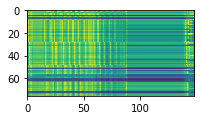

Count 800 | 금요일 저녁에 동창회 잡으려고 하는데 2층에 25명 정도 예약 받을 수 있나요? _____ => 금요일 저녁에 창가잡으  잡고   2명                 수수나         


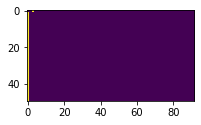

Count 800 | 금요일 저녁에 동창회 잡으려고 하는데 2층에 25명 정도 예약 받을 수 있나요? _____ => <s>앙ㅇㅇ앙이이아이아아아아이이이이아아아아ㅏ아아아이나요?</s> => 안녕                                                


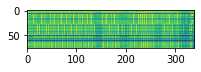

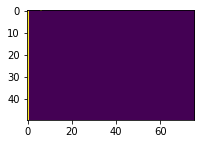

09-26 22:33:06
Mean Train Loss: 0.06225020599161355
Mean Train Seq2Seq Loss: 3.6608285753957834
Train CER: 0.9556986428130784
Mean Train Reference Seq2Seq Loss: 0.6857372374497149
Train Reference CER: 0.3181749475893282
Eval Count 50 | 단체로 앉을 따로 룸이 있나요~? __ => 단체로 앉을 바로 따로 있나요~?   


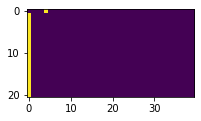

Eval Count 50 | 단체로 앉을 따로 룸이 있나요~? __ => <s>아ㅏㅣ강 아나요?</s> => None


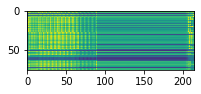

09-26 22:33:24
Mean Evaluation Loss: 0.07109539107796503
Mean Evaluation Seq2Seq Loss: 4.124354265153159
Evaluation CER: 0.9833007371746653
Mean Evaluation Reference Seq2Seq Loss: 1.0150323347679413
Evaluation Reference CER: 0.36339913425229486


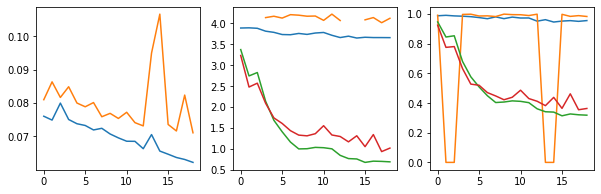

-------------------------------------------------------------------------------------------------------
09-26 22:33:25
Count 200 | 이번 달은 언제 언제 쉬어요? __ => 이번 달은 언제 언제 쉬어요?   


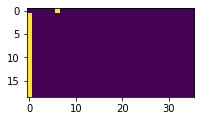

Count 200 | 이번 달은 언제 언제 쉬어요? __ => <s>이이아이이아이이시 이나요?</s> => None


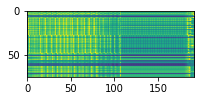

Count 400 | 런치타임 주중이랑 주말이랑 시간이 다른가요? ____ => 런치랑랑 주말이랑 주말이랑 시간이 다른가요?     


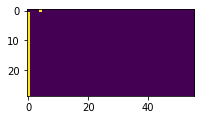

Count 400 | 런치타임 주중이랑 주말이랑 시간이 다른가요? ____ => <s>주잇이싯이가이가ㅏ가우가ㅏ 이나요?</s> => 주차                     요요?   


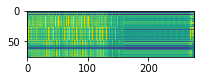

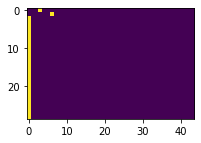

Count 600 | 아웃백은 얼마나 버나요? ___ => 아웃백은 얼마나 버나요?    


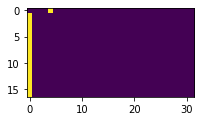

Count 600 | 아웃백은 얼마나 버나요? ___ => <s>아아아가 히나요?</s> => None


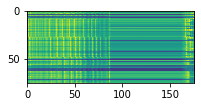

Count 800 | 거기 혹시 지갑보관 중인게 있나요? ______ => 거기 혹시 지갑 관관 인 있나나?        


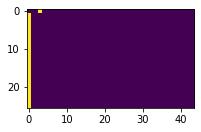

Count 800 | 거기 혹시 지갑보관 중인게 있나요? ______ => <s>아이으시시아시잉 이나요?</s> => None


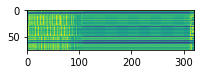

09-26 22:43:45
Mean Train Loss: 0.06151381514882772
Mean Train Seq2Seq Loss: 3.665564563320045
Train CER: 0.9515498754589464
Mean Train Reference Seq2Seq Loss: 0.6710193320245027
Train Reference CER: 0.3162867930495977
Eval Count 50 | 지금 다와가는데 5명 자리 있나요? __ => 지금 면와와데데  자자자리 있나요?   


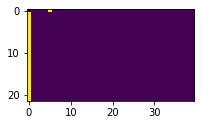

Eval Count 50 | 지금 다와가는데 5명 자리 있나요? __ => <s>*ㅇ아ㅏㅇ사히나요?</s> => None


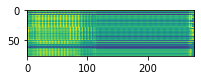

09-26 22:44:03
Mean Evaluation Loss: 0.06928210275531066
Mean Evaluation Seq2Seq Loss: 4.205283002703836
Evaluation CER: 0.9909190699530985
Mean Evaluation Reference Seq2Seq Loss: 1.1315649310809366
Evaluation Reference CER: 0.4055094063034449


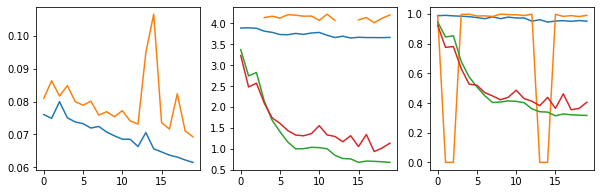

-------------------------------------------------------------------------------------------------------
09-26 22:44:04
Count 200 | 음료는 뭐가 있나요? _ => 음료는 뭐가 있나요?  


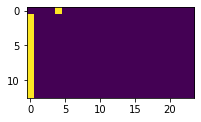

Count 200 | 음료는 뭐가 있나요? _ => <s>예ㅏ아아ㅏ하나요?</s> => None


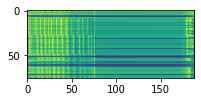

Count 400 | 보통 아웃백 얼마나 영업하나요? ___ => 보통 아웃백 영업  업하나요?     


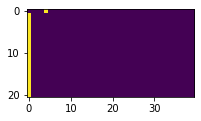

Count 400 | 보통 아웃백 얼마나 영업하나요? ___ => <s>ㅇ이아아아아아아아아아나요?</s> => None


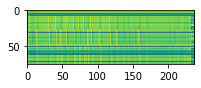

Count 600 | 생일 할인이랑 멤버십 할인 같이 사용 가능한가요? _____ => 생일 할인이랑 멤버십 할인 같이 사용 가능한가요?      


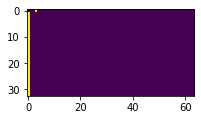

Count 600 | 생일 할인이랑 멤버십 할인 같이 사용 가능한가요? _____ => <s>ㅇ이아아아아이아아아이아아있나요?</s> => 아                        요요?     


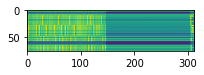

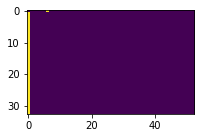

Count 800 | 7명도 단체예약이 되나요? __ => 2명도 단체예약이 되나요?   


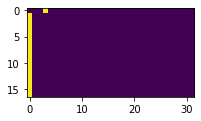

Count 800 | 7명도 단체예약이 되나요? __ => <s>ㅇ시아아아아아아아하나요?</s> => None


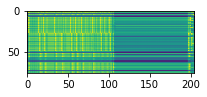

09-26 22:54:22
Mean Train Loss: 0.06305773618892212
Mean Train Seq2Seq Loss: 3.6677461491981918
Train CER: 0.9503339996528419
Mean Train Reference Seq2Seq Loss: 0.6811236688788892
Train Reference CER: 0.31797217792929017
Eval Count 50 | 지금 이벤트 할인 중인 메뉴가 무엇이 있나요? _____ => 지금 할인  인인 중인 메뉴가 무무엇이 있나요?     


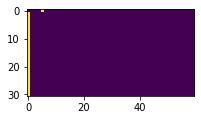

Eval Count 50 | 지금 이벤트 할인 중인 메뉴가 무엇이 있나요? _____ => <s>이인나요?</s> => 안                              


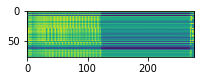

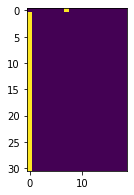

09-26 22:54:39
Mean Evaluation Loss: 0.07492659761432557
Mean Evaluation Seq2Seq Loss: 4.061060396495923
Evaluation CER: 0.9958098307816278
Mean Evaluation Reference Seq2Seq Loss: 1.0850819808003926
Evaluation Reference CER: 0.37103323808091443


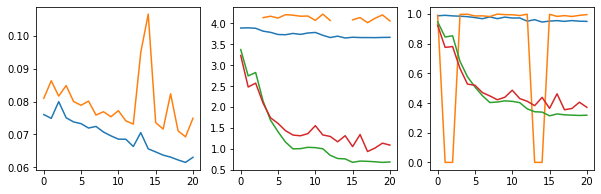

-------------------------------------------------------------------------------------------------------
09-26 22:54:40
Count 200 | 할인 받을 수 있는 통신사는 어디인가요? ____ => 할인 받을 수 있는 통신사는 어떤인가요?     


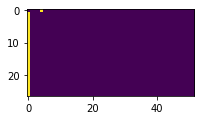

Count 200 | 할인 받을 수 있는 통신사는 어디인가요? ____ => <s>ㅈ아아이아아아아아아아나요?</s> => 혹일                         


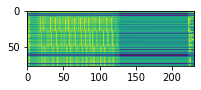

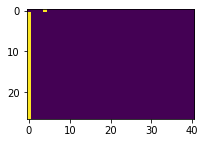

Count 400 | 경산이랑 가까운 위치에 있나요? ___ => 경산이랑 가장운 위치  있나요?    


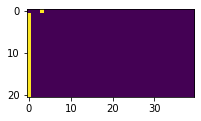

Count 400 | 경산이랑 가까운 위치에 있나요? ___ => <s>자이아아이가이나요?</s> => None


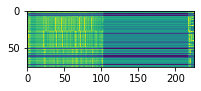

Count 600 | 라스트 오더는 몇시인가요? __ => 라스트 오더는 몇시인가요?   


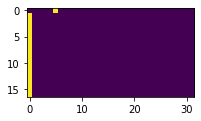

Count 600 | 라스트 오더는 몇시인가요? __ => <s>아이아아아이ㅣㅣ 이나요?</s> => None


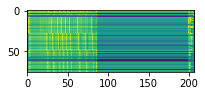

Count 800 | 블랙 라벨 스테이크 메뉴에서 패밀리 세트 가격이 제일 저렴한메뉴는 얼마일까요? ______ => 블랙라라벨 스테이크 세트 메뉴                        얼얼마 까?????


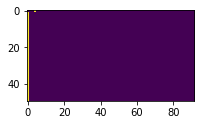

Count 800 | 블랙 라벨 스테이크 메뉴에서 패밀리 세트 가격이 제일 저렴한메뉴는 얼마일까요? ______ => <s>이이이이아아아앙아아아아아아아아아아아아 아나요?</s> => 네                                                 


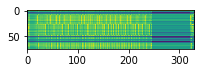

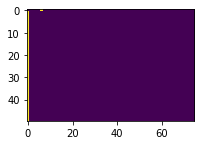

09-26 23:04:54
Mean Train Loss: 0.0625534518842134
Mean Train Seq2Seq Loss: 3.652905865086909
Train CER: 0.9493206840009369
Mean Train Reference Seq2Seq Loss: 0.6758353430854204
Train Reference CER: 0.31514123573856284
Eval Count 50 | 단체할인은 얼마나 되는 건 가요? __ => 단체할인은 얼마나 되는  건가요?   


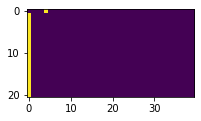

Eval Count 50 | 단체할인은 얼마나 되는 건 가요? __ => <s>자 안나요?</s> => None


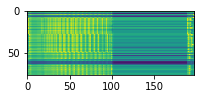

09-26 23:05:12
Mean Evaluation Loss: 0.07396134469377279
Mean Evaluation Seq2Seq Loss: 4.206386284298548
Evaluation CER: 0.99
Mean Evaluation Reference Seq2Seq Loss: 1.0913982663381454
Evaluation Reference CER: 0.36177112198573197


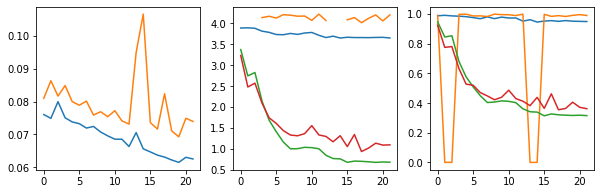

-------------------------------------------------------------------------------------------------------
09-26 23:05:13
Count 200 | 성남시에 있는 아웃백 지점이 어디인가요? ____ => 성인에 있는  이        인인요?      


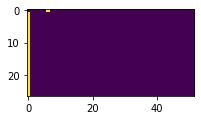

Count 200 | 성남시에 있는 아웃백 지점이 어디인가요? ____ => <s>자아이이아이아아아하나요?</s> => 지체                         


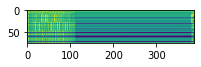

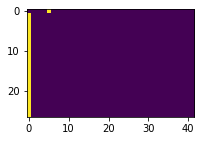

Count 400 | 예약 할 수 있을까요? _ => 예약 할 수 있을까요?  


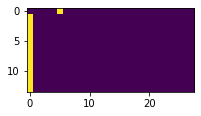

Count 400 | 예약 할 수 있을까요? _ => <s>여이이이아가 이나요?</s> => None


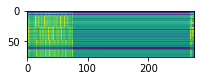

Count 600 | 생일 쿠폰은 어떻게 받을 수 있나요? ___ => 생일 쿠폰은 어떻게 받을 수 있나요?    


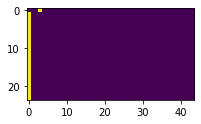

Count 600 | 생일 쿠폰은 어떻게 받을 수 있나요? ___ => <s>아아아사아아아아아아가 하가요?</s> => None


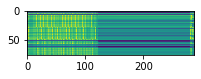

Count 800 | 아기 돌잔치를 할 장소를 찾고 있어요 아웃백에서 돌잔치 서비스를 제공하나요? ______ => 아기  잔치를 를를                     서 서  비용나나나????    


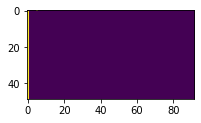

Count 800 | 아기 돌잔치를 할 장소를 찾고 있어요 아웃백에서 돌잔치 서비스를 제공하나요? ______ => <s>아이이이이아이아이시아아아아아이이이시기기 이나요?</s> => 아웃                                      요 요 ?    


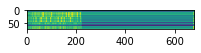

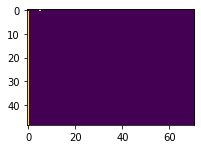

09-26 23:15:33
Mean Train Loss: 0.06111545338619544
Mean Train Seq2Seq Loss: 3.6732249660820493
Train CER: 0.9551897264250828
Mean Train Reference Seq2Seq Loss: 0.6809977844618414
Train Reference CER: 0.3193039140041385
Eval Count 50 | 창가쪽 자리가  있나요? _ => 창가쪽 자리리   있나요? 


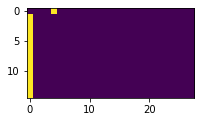

Eval Count 50 | 창가쪽 자리가  있나요? _ => <s>아 아나요?</s> => None


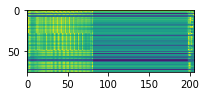

09-26 23:15:50
Mean Evaluation Loss: 0.0734937508641544
Mean Evaluation Seq2Seq Loss: 4.133878467084655
Evaluation CER: 0.9865070315469403
Mean Evaluation Reference Seq2Seq Loss: 1.2014197214347366
Evaluation Reference CER: 0.3800060771801884


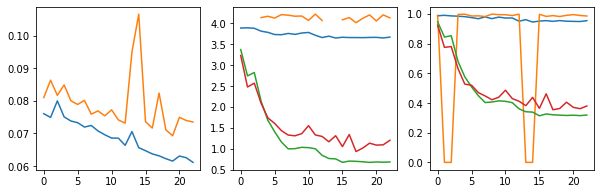

-------------------------------------------------------------------------------------------------------
09-26 23:15:51
Count 200 | 한 가지 메뉴도 배달이 되나요? _ => 한 가지 메뉴도 배달이 되나요?  


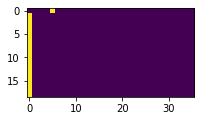

Count 200 | 한 가지 메뉴도 배달이 되나요? _ => <s>아아지이이이이나요?</s> => None


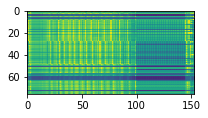

Count 400 | 지금 2명이서 가려는데 대기 시간이 많이 기나요? _ => 지금 1명이서 가려는데 기기 시간이 이이  나요?? 


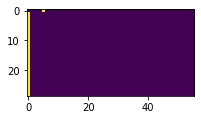

Count 400 | 지금 2명이서 가려는데 대기 시간이 많이 기나요? _ => <s>이시아아아으이아이있나요?</s> => 생일                   요요?     


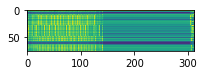

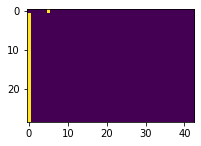

Count 600 | 네 혹시 예약 가능한가요? ___ => 네 혹시 예약 가능한가요?    


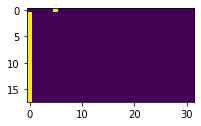

Count 600 | 네 혹시 예약 가능한가요? ___ => <s>줏이이이시이이각ㅇ한가요?</s> => None


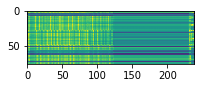

Count 800 | 노원점이 노원역 근처에 있는거죠? _____ => 노원역  노이역 근처에 있겠죠?       


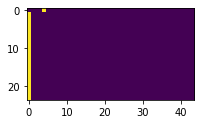

Count 800 | 노원점이 노원역 근처에 있는거죠? _____ => <s>자아아아이아아아아가 이나요?</s> => None


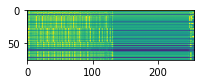

09-26 23:26:13
Mean Train Loss: 0.06073044489977762
Mean Train Seq2Seq Loss: 3.6518175020202013
Train CER: 0.9495827202130973
Mean Train Reference Seq2Seq Loss: 0.673953384372081
Train Reference CER: 0.3170752040858861
Eval Count 50 | 그럼 30분 후에 갈게요 _ => 그럼  0에에 찾으 갈게요 


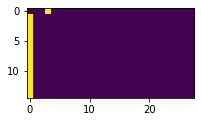

Eval Count 50 | 그럼 30분 후에 갈게요 _ => <s>아 이나요?</s> => None


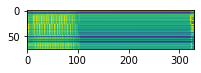

09-26 23:26:30
Mean Evaluation Loss: 0.07475332183656308
Mean Evaluation Seq2Seq Loss: 4.044919004716871
Evaluation CER: 0.989957264957265
Mean Evaluation Reference Seq2Seq Loss: 1.3949650443587585
Evaluation Reference CER: 0.40746282329231426


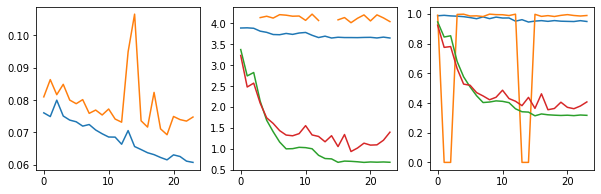

-------------------------------------------------------------------------------------------------------
09-26 23:26:31
Count 200 | 오늘 오후  5시에 영업하나요? _ => 오늘 오후  5시에 영업하나요?  


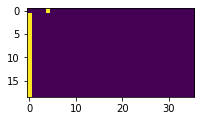

Count 200 | 오늘 오후  5시에 영업하나요? _ => <s>오아이이이으아 하나요?</s> => None


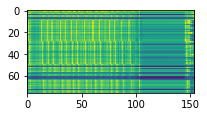

Count 400 | 영업 쉬는 날 있어요? __ => 영업 쉬는 날  어요?   


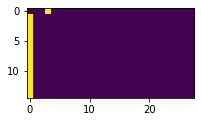

Count 400 | 영업 쉬는 날 있어요? __ => <s>예아가아 이나요?</s> => None


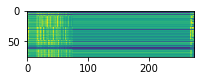

Count 600 | 오늘 저녁 8시 30분 쯤 방문 포장 예약하려고 하는데요 _ => 오늘 저녁 7시  방문   포장 포장 예약하려고 는는    


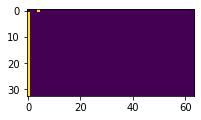

Count 600 | 오늘 저녁 8시 30분 쯤 방문 포장 예약하려고 하는데요 _ => <s>여느이으으이시수서나가나아ㅡㅡㅏ낭느 힌나요?</s> => 오                                


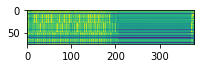

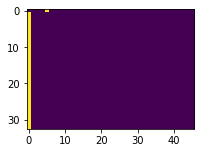

Count 800 | 주말에 가려고 하는데 예약 해야 하나요?  => 주말에 가려고 하는데 예약 해야 하나요? 


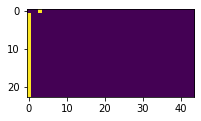

Count 800 | 주말에 가려고 하는데 예약 해야 하나요?  => <s>지아이ㅏ아이이이이이나요?</s> => None


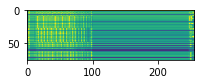

09-26 23:37:01
Mean Train Loss: 0.06024245734045812
Mean Train Seq2Seq Loss: 3.657252546278222
Train CER: 0.9516853302615282
Mean Train Reference Seq2Seq Loss: 0.6966323098404049
Train Reference CER: 0.320187745971614
Eval Count 50 | 내일 먹을꺼라서 반조리상태로 보내주실수 있나요? ___ => 내일 선쉬 쉬서 소로 로로   보주  수나나나요    


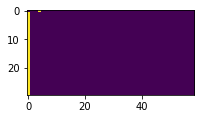

Eval Count 50 | 내일 먹을꺼라서 반조리상태로 보내주실수 있나요? ___ => <s>옹ㅇ아ㅏㅏ자ㅏㅏ시이ㅏㅇ아ㅏ아ㅣ이 이나요?</s> => 안                             


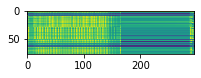

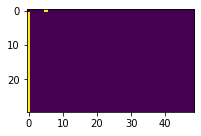

09-26 23:37:19
Mean Evaluation Loss: 0.0696631910099138
Mean Evaluation Seq2Seq Loss: 4.045934260943005
Evaluation CER: 0.9893987801336044
Mean Evaluation Reference Seq2Seq Loss: 1.1676314681995215
Evaluation Reference CER: 0.38332377012049645


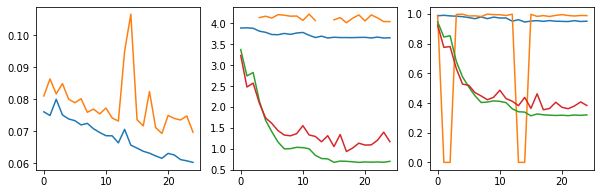

-------------------------------------------------------------------------------------------------------
09-26 23:37:19


KeyboardInterrupt: 

In [25]:
EPOCH = 6 * 10
           
# net = Mel2SeqNet(80, 512, 256)


# net = Mel2SeqNet(80, 1024, 512, len(unicode_jamo_list), device)

# keyword = 'NSML_pure_jamo_50ms_pad_cut'
# net = Mel2SeqNet(80, 512, 256, len(unicode_jamo_list), device)

# keyword = 'NSML_pure_jamo_50ms_pad_cut_1024'

# keyword = 'NSML_pure_jamo_50ms_pad_cut_1024_copy'

net = Mel2SeqNet(80, 1024, 512, len(unicode_jamo_list), device)
net_optimizer = optim.Adam(net.parameters(), lr=0.001)
ctc_loss = nn.CTCLoss().to(device)

# try:
#     load(net, net_optimizer, 'model_saved/{}'.format(keyword))
# except:
#     print('Failed to load model')

keyword = 'NSML_jamo_seq2seq_from_scratch_seq2seq_repeat_4'

jamo2char_net = Seq2SeqNet(512, jamo_tokens, char2index, device)
jamo2char_optimizer = optim.Adam(jamo2char_net.parameters(), lr=0.001)
seq2seq_criterion = nn.NLLLoss(reduction='none').to(device)

train_loss_history = list()
eval_loss_history = list()

train_seq2seq_loss_history = list()
eval_seq2seq_loss_history = list()

train_seq2seq_loss_history_ref = list()
eval_seq2seq_loss_history_ref = list()

train_cer_history = list()
eval_cer_history = list()

train_cer_history_ref = list()
eval_cer_history_ref = list()

try:
    train_cer_history = list(np.load('model_saved/train_cer_history_{}.npy'.format(keyword)))
    eval_cer_history = list(np.load('model_saved/eval_cer_history_{}.npy'.format(keyword)))
except:
    print("No CER Record")
    
try:
    load(jamo2char_net, jamo2char_optimizer, 'model_saved/seq_{}'.format(keyword))
    train_seq2seq_loss_history = list(np.load('model_saved/train_seq_loss_history_{}.npy'.format(keyword)))
    eval_seq2seq_loss_history = list(np.load('model_saved/eval_seq_loss_history_{}.npy'.format(keyword)))
except:
    print('No Seq2Seq Loss Record')
    
try:
#     load(net, net_optimizer, 'model_saved/{}'.format(keyword))
    train_loss_history = list(np.load('model_saved/train_loss_history_{}.npy'.format(keyword)))
    eval_loss_history = list(np.load('model_saved/eval_loss_history_{}.npy'.format(keyword)))
except:
    print("Loading {} Loss History Error".format(keyword))

# keyword = 'NSML_pure_jamo_50ms_pad_cut_1024_copy'

min_loss_net = 1e+10
min_loss_seq = 1e+10

for epoch in range(EPOCH):

    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    
    try:
        load(net, net_optimizer, 'model_saved/{}'.format(keyword))
    except:
        print('Could not found model_saved/{}'.format(keyword))
        
    try:
        load(jamo2char_net, jamo2char_optimizer, 'model_saved/seq_{}'.format(keyword))
    except:
        print('Could not found model_saved/seq_{}'.format(keyword))

    preloader_train.initialize_batch(num_thread)
    loss_list_train = list()
    seq2seq_loss_list_train = list()
    seq2seq_loss_list_train_ref = list()

    total_dist = 0
    total_length = 1
    total_dist_ref = 0
    total_length_ref = 1
    
    count = 0
    net.train()
    jamo2char_net.train()
    
    while preloader_train.end_flag == False:
        batch = preloader_train.get_batch()
        # logger.info("Got Batch")
        if batch != None:
            tensor_input, ground_truth, loss_mask, length_list, lev_truth, lev_truth_loss_mask = batch
            
            pred_tensor, loss = train(net, net_optimizer, ctc_loss, tensor_input.to(device),
                                          ground_truth.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_train.append(loss)

            jamo_result = Decode_Prediction_No_Filtering(pred_tensor, tokenizer)
            
            true_string_list = Decode_Lev_Truth(lev_truth.detach().cpu().numpy(), index2char)
            
            lev_input_ref = ground_truth
            lev_pred_ref, attentions_ref, seq2seq_loss_ref = jamo2char_net.net_train(lev_input_ref.to(device), lev_truth.to(device), lev_truth_loss_mask.to(device), jamo2char_optimizer, seq2seq_criterion)
            pred_string_list_ref = Decode_Lev(lev_pred_ref, index2char)
            seq2seq_loss_list_train_ref.append(seq2seq_loss_ref)
            dist_ref, length_ref = char_distance_list(true_string_list, pred_string_list_ref)
            
            pred_string_list = [None]
            
            dist = 0
            length = 0
            
            if (loss < 0.05):
                lev_input = Decode_Jamo_Prediction_And_Batch(pred_tensor)
                lev_pred, attentions, seq2seq_loss = jamo2char_net.net_train(lev_input.to(device), lev_truth.to(device), lev_truth_loss_mask.to(device), jamo2char_optimizer, seq2seq_criterion)
                pred_string_list = Decode_Lev(lev_pred, index2char)
                seq2seq_loss_list_train.append(seq2seq_loss)  
                dist, length = char_distance_list(true_string_list, pred_string_list)                

            total_dist_ref += dist_ref
            total_length_ref += length_ref
            
            total_dist += dist
            total_length += length
            
            count += 1
            if count % 200 == 0:
                print("Count {} | {} => {}".format(count, true_string_list[0], pred_string_list_ref[0]))
                
                plt.figure(figsize = (3, 3))
                plt.imshow(attentions_ref[0].detach().cpu().numpy().T)
                plt.show()
                
                print("Count {} | {} => {} => {}".format(count, true_string_list[0], jamo_result[0], pred_string_list[0]))
                plt.figure(figsize = (3, 3))
                plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy().T)
                plt.show()
                
                if pred_string_list[0] is not None:
                    plt.figure(figsize = (3, 3))
                    plt.imshow(attentions[0].detach().cpu().numpy().T)
                    plt.show()

    train_cer = total_dist / total_length
    train_loss = np.mean(np.asarray(loss_list_train))
    train_seq2seq_loss = np.mean(np.asarray(seq2seq_loss_list_train))
    
    train_cer_ref = total_dist_ref / total_length_ref
    train_seq2seq_loss_ref = np.mean(np.asarray(seq2seq_loss_list_train_ref))
    
    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    print("Mean Train Loss: {}".format(train_loss))
    print("Mean Train Seq2Seq Loss: {}".format(train_seq2seq_loss))
    print("Train CER: {}".format(train_cer))
    print("Mean Train Reference Seq2Seq Loss: {}".format(train_seq2seq_loss_ref))
    print("Train Reference CER: {}".format(train_cer_ref))
    
    train_loss_history.append(train_loss)
    train_cer_history.append(train_cer)
    train_cer_history_ref.append(train_cer_ref)
    
    train_seq2seq_loss_history.append(train_seq2seq_loss)
    train_seq2seq_loss_history_ref.append(train_seq2seq_loss_ref)
    
    ###########################################################
    
    preloader_eval.initialize_batch(num_thread)
    loss_list_eval = list()
    seq2seq_loss_list_eval = list()
    seq2seq_loss_list_eval_ref = list()

    total_dist = 0
    total_length = 1
    total_dist_ref = 0
    total_length_ref = 1
    
    net.eval()
    jamo2char_net.eval()
    
    count = 0
    
    while preloader_eval.end_flag == False:
        batch = preloader_eval.get_batch()
        if batch != None:
            tensor_input, ground_truth, loss_mask, length_list, lev_truth, lev_truth_loss_mask = batch

            pred_tensor, loss = evaluate(net, ctc_loss, tensor_input.to(device),
                                      ground_truth.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_eval.append(loss)
            
            jamo_result = Decode_Prediction_No_Filtering(pred_tensor, tokenizer)
            
            true_string_list = Decode_Lev_Truth(lev_truth.detach().cpu().numpy(), index2char)
            
            lev_input_ref = ground_truth
            lev_pred_ref, attentions_ref, seq2seq_loss_ref = jamo2char_net.net_eval(lev_input_ref.to(device), lev_truth.to(device), lev_truth_loss_mask.to(device), seq2seq_criterion)
            pred_string_list_ref = Decode_Lev(lev_pred_ref, index2char)
            seq2seq_loss_list_eval_ref.append(seq2seq_loss_ref)
            dist_ref, length_ref = char_distance_list(true_string_list, pred_string_list_ref)
            
            pred_string_list = [None]
            
            dist = 0
            length = 0
            
            if (loss < 0.05):
                lev_input = Decode_Jamo_Prediction_And_Batch(pred_tensor)
                lev_pred, attentions, seq2seq_loss = jamo2char_net.net_eval(lev_input.to(device), lev_truth.to(device), lev_truth_loss_mask.to(device), seq2seq_criterion)
                pred_string_list = Decode_Lev(lev_pred, index2char)
                seq2seq_loss_list_eval.append(seq2seq_loss)  
                dist, length = char_distance_list(true_string_list, pred_string_list)
                                
            total_dist_ref += dist_ref
            total_length_ref += length_ref
            
            total_dist += dist
            total_length += length
            
            count += 1
            if count % 50 == 0:
                print("Eval Count {} | {} => {}".format(count, true_string_list[0], pred_string_list_ref[0]))
                
                plt.figure(figsize = (3, 3))
                plt.imshow(attentions_ref[0].detach().cpu().numpy().T)
                plt.show()
                
                print("Eval Count {} | {} => {} => {}".format(count, true_string_list[0], jamo_result[0], pred_string_list[0]))
                plt.figure(figsize = (3, 3))
                plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy().T)
                plt.show()
                
                if pred_string_list[0] is not None:
                    plt.figure(figsize = (3, 3))
                    plt.imshow(attentions[0].detach().cpu().numpy().T)
                    plt.show()
            
    eval_cer = total_dist / total_length
    eval_loss = np.mean(np.asarray(loss_list_eval))
    eval_seq2seq_loss = np.mean(np.asarray(seq2seq_loss_list_eval)) ##############
    
    eval_cer_ref = total_dist_ref / total_length_ref
    eval_seq2seq_loss_ref = np.mean(np.asarray(seq2seq_loss_list_eval_ref)) ##############
    

    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    print("Mean Evaluation Loss: {}".format(eval_loss))
    print("Mean Evaluation Seq2Seq Loss: {}".format(eval_seq2seq_loss)) ##################
    print("Evaluation CER: {}".format(eval_cer))
    print("Mean Evaluation Reference Seq2Seq Loss: {}".format(eval_seq2seq_loss_ref)) ##################
    print("Evaluation Reference CER: {}".format(eval_cer_ref))
    
    
    eval_loss_history.append(eval_loss)
    eval_cer_history.append(eval_cer)
    eval_cer_history_ref.append(eval_cer_ref)
    
    eval_seq2seq_loss_history.append(eval_seq2seq_loss) ##################
    eval_seq2seq_loss_history_ref.append(eval_seq2seq_loss_ref) ##################
    
    #####
    
#     if min_loss_net > train_loss:
#         min_loss_net = train_loss

    save(net, net_optimizer, 'model_saved/{}'.format(keyword))
    
    if min_loss_seq > train_seq2seq_loss:
        min_loss_seq = train_seq2seq_loss
        save(jamo2char_net, jamo2char_optimizer, 'model_saved/seq_{}'.format(keyword))
    
    np.save('model_saved/train_loss_history_{}'.format(keyword), train_loss_history)
    np.save('model_saved/eval_loss_history_{}'.format(keyword), eval_loss_history)
    
    np.save('model_saved/train_seq_loss_history_{}'.format(keyword), train_seq2seq_loss_history)
    np.save('model_saved/eval_seq_loss_history_{}'.format(keyword), eval_seq2seq_loss_history)
    
    np.save('model_saved/train_cer_history_{}'.format(keyword), train_cer_history)
    np.save('model_saved/eval_cer_history_{}'.format(keyword), eval_cer_history)
            
    #####    
    
    plt.figure(figsize=(10, 3))
    plt.subplot(131)
    plt.plot(train_loss_history)
    plt.plot(eval_loss_history)

    plt.subplot(132)
    plt.plot(train_seq2seq_loss_history)
    plt.plot(eval_seq2seq_loss_history)
    
    plt.plot(train_seq2seq_loss_history_ref)
    plt.plot(eval_seq2seq_loss_history_ref)

    plt.subplot(133)
    plt.plot(train_cer_history)
    plt.plot(eval_cer_history)
    
    plt.plot(train_cer_history_ref)
    plt.plot(eval_cer_history_ref)
    
    plt.show()
        
    print("-------------------------------------------------------------------------------------------------------")
    
    